In [1]:
%run ./check_DOVS_METHODS_OLD.ipynb

In [2]:
from importlib import reload
#reload(Utilities)
#reload(clm)

import sys, os
import re

import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype, is_datetime64_dtype, is_timedelta64_dtype
from scipy import stats
import datetime
import time
from natsort import natsorted, ns
from packaging import version

import copy

import itertools

import pyodbc
#---------------------------------------------------------------------
sys.path.insert(0, os.path.realpath('..'))
import Utilities_config
#-----
import CommonLearningMethods as clm
#-----
from MeterPremise import MeterPremise
#-----
from AMI_SQL import AMI_SQL
from AMINonVee_SQL import AMINonVee_SQL
from AMIEndEvents_SQL import AMIEndEvents_SQL
from AMIUsgInst_SQL import AMIUsgInst_SQL
from DOVSOutages_SQL import DOVSOutages_SQL
#-----
from GenAn import GenAn
from AMINonVee import AMINonVee
from AMIEndEvents import AMIEndEvents
from AMIUsgInst import AMIUsgInst
from DOVSOutages import DOVSOutages
#---------------------------------------------------------------------
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib import dates
#---------------------------------------------------------------------
sys.path.insert(0, Utilities_config.get_sql_aids_dir())
import Utilities_sql
import TableInfos
from TableInfos import TableInfo
from SQLElement import SQLElement
from SQLElementsCollection import SQLElementsCollection
from SQLSelect import SQLSelectElement, SQLSelect
from SQLFrom import SQLFrom
from SQLWhere import SQLWhereElement, SQLWhere
from SQLJoin import SQLJoin, SQLJoinCollection
from SQLGroupBy import SQLGroupByElement, SQLGroupBy
from SQLHaving import SQLHaving
from SQLOrderBy import SQLOrderByElement, SQLOrderBy
from SQLQuery import SQLQuery
from SQLQueryGeneric import SQLQueryGeneric
#---------------------------------------------------------------------
sys.path.insert(0, Utilities_config.get_utilities_dir())
import Utilities
import Utilities_df
import Utilities_dt
from Utilities_df import DFConstructType
import Plot_General
import Plot_Box_sns
import GrubbsTest
import DataFrameSubsetSlicer
from DataFrameSubsetSlicer import DataFrameSubsetSlicer as DFSlicer

# Analyze collected data

## AMI NonVee

In [3]:
#-------------------------
calculate_by_PN = True
#-------------------------

In [4]:
#-------------------------
paths = Utilities.find_all_paths(
#     base_dir=r'C:\Users\s346557\Documents\LocalData\dovs_check\forAmanda\SN_882735506\AMINonVee', 
    base_dir=r'C:\Users\s346557\Documents\LocalData\dovs_check\20230806_20230812\AllOPCOs\AMINonVee', 
#     base_dir=r'C:\Users\s346557\Documents\LocalData\dovs_check\forMico2\AMINonVee', 
    glob_pattern=r'ami_nonvee_[0-9]*.csv', 
    regex_pattern=None
)
paths=natsorted(paths)
#-------------------------
outg_rec_nbs_in_files = dict()
for path in paths:
    assert(path not in outg_rec_nbs_in_files.keys())
    df = GenAn.read_df_from_csv(path)
    outg_rec_nbs_in_files[path] = df['OUTG_REC_NB_GPD_FOR_SQL'].unique().tolist()
outg_rec_nb_to_files_dict = invert_file_to_outg_rec_nbs_dict(outg_rec_nbs_in_files)
all_outg_rec_nbs = list(outg_rec_nb_to_files_dict.keys())

In [5]:
#-------------------------
paths_ede = Utilities.find_all_paths(
#     base_dir=r'C:\Users\s346557\Documents\LocalData\dovs_check\forAmanda\SN_882735506\EndEvents', 
    base_dir=r'C:\Users\s346557\Documents\LocalData\dovs_check\20230806_20230812\AllOPCOs\EndEvents', 
#     base_dir=r'C:\Users\s346557\Documents\LocalData\dovs_check\forMico2\EndEvents', 
    glob_pattern=r'end_events_[0-9]*.csv', 
    regex_pattern=None
)
paths_ede=natsorted(paths_ede)
#-------------------------
outg_rec_nbs_in_files_ede = dict()
for path in paths_ede:
    assert(path not in outg_rec_nbs_in_files_ede.keys())
    df = GenAn.read_df_from_csv(path)
    outg_rec_nbs_in_files_ede[path] = df['OUTG_REC_NB_GPD_FOR_SQL'].unique().tolist()
outg_rec_nb_to_files_ede_dict = invert_file_to_outg_rec_nbs_dict(outg_rec_nbs_in_files_ede)
all_outg_rec_nbs_ede = list(outg_rec_nb_to_files_ede_dict.keys())

In [6]:
#-------------------------
instvabc_slcr = DFSlicer(
    single_slicers = [
        dict(
            column='aep_derived_uom', 
            value='VOLT', 
            comparison_operator='=='
        ), 
        dict(
            column='aep_srvc_qlty_idntfr', 
            value=['INSTVA1', 'INSTVB1', 'INSTVC1'], 
            comparison_operator='isin'
        )
    ], 
    name='VOLT, INSTV(ABC)1', 
    join_single_slicers='and'
)
#-------------------------
volt_avg_slcr = DFSlicer(
    single_slicers = [
        dict(
            column='aep_derived_uom', 
            value='VOLT', 
            comparison_operator='=='
        ), 
        dict(
            column='aep_srvc_qlty_idntfr', 
            value='AVG', 
            comparison_operator='=='
        )
    ], 
    name='VOLT, AVG', 
    join_single_slicers='and'
)
#-------------------------
slicers=[instvabc_slcr, volt_avg_slcr]

In [7]:
outg_rec_nbs_in_files

{'C:\\Users\\s346557\\Documents\\LocalData\\dovs_check\\20230806_20230812\\AllOPCOs\\AMINonVee\\ami_nonvee_0.csv': ['13530371',
  '13530363',
  '13530364'],
 'C:\\Users\\s346557\\Documents\\LocalData\\dovs_check\\20230806_20230812\\AllOPCOs\\AMINonVee\\ami_nonvee_1.csv': ['13530422',
  '13530423',
  '13530430'],
 'C:\\Users\\s346557\\Documents\\LocalData\\dovs_check\\20230806_20230812\\AllOPCOs\\AMINonVee\\ami_nonvee_2.csv': ['13530430',
  '13530432',
  '13530437',
  '13530438'],
 'C:\\Users\\s346557\\Documents\\LocalData\\dovs_check\\20230806_20230812\\AllOPCOs\\AMINonVee\\ami_nonvee_3.csv': ['13530438'],
 'C:\\Users\\s346557\\Documents\\LocalData\\dovs_check\\20230806_20230812\\AllOPCOs\\AMINonVee\\ami_nonvee_4.csv': ['13530438'],
 'C:\\Users\\s346557\\Documents\\LocalData\\dovs_check\\20230806_20230812\\AllOPCOs\\AMINonVee\\ami_nonvee_5.csv': ['13530442',
  '13530438',
  '13530444',
  '13530450'],
 'C:\\Users\\s346557\\Documents\\LocalData\\dovs_check\\20230806_20230812\\AllOPCOs\\A

In [8]:
# start = time.time()
# outg_rec_nbs_to_remove = identify_outg_rec_nbs_to_remove(
#     paths=paths,
#     slicers=slicers, 
#     verbose=True
# )
# print(time.time()-start)

In [84]:
# outg_rec_nb = '13149414'
# outg_rec_nb = '13154561'
# outg_rec_nb = '13164863'
outg_rec_nb = '13162958'
# outg_rec_nb = '13149508'

# outg_rec_nb = '13155204' # 16 SNs, 15 PNs
outg_rec_nb = '13297273'
outg_rec_nb = '13530363'

outg_rec_nb = '13531467'

In [85]:
outg_rec_nb_to_files_dict[outg_rec_nb]

['C:\\Users\\s346557\\Documents\\LocalData\\dovs_check\\20230806_20230812\\AllOPCOs\\AMINonVee\\ami_nonvee_20.csv']

In [86]:
start=time.time()

ami_df = GenAn.read_df_from_csv_batch(outg_rec_nb_to_files_dict[outg_rec_nb])
#-------------------------
ami_df_i = ami_df[ami_df['OUTG_REC_NB_GPD_FOR_SQL']==outg_rec_nb].copy()

# Although I cannot yet call choose_best_slicer_and_perform_slicing and reduce_INSTV_ABC_1_vals_in_df, 
#   as the standard cleaning and conversions must be done first, I am able to cut down the size of
#   ami_df_i by joining the slicers with 'or' statements.
# Thus, ami_df_i will be reduced to only the subset of data which will be considered in 
#   choose_best_slicer_and_perform_slicing
# As mentioned, this will cut down the size of ami_df_i and will also save time and resources by not having
#   to run entire DF through cleaning and conversions procedures.
ami_df_i = DFSlicer.combine_slicers_and_perform_slicing(
    df=ami_df_i, 
    slicers=slicers, 
    join_slicers='or'
)


if ami_df_i.shape[0]==0:
    print('No usable data in ami_df_i')
    assert(0)

#-------------------------
ami_df_i = AMINonVee.perform_std_initiation_and_cleaning(ami_df_i)
#-----
# Should the following be added to AMINonVee.perform_std_initiation_and_cleaning?
ami_df_i = Utilities_dt.strip_tz_info_and_convert_to_dt(
    df=ami_df_i, 
    time_col='starttimeperiod', 
    placement_col='starttimeperiod_local', 
    run_quick=True, 
    n_strip=6, 
    inplace=False
)
ami_df_i = Utilities_dt.strip_tz_info_and_convert_to_dt(
    df=ami_df_i, 
    time_col='endtimeperiod', 
    placement_col='endtimeperiod_local', 
    run_quick=True, 
    n_strip=6, 
    inplace=False
)
idk = ami_df_i.copy()
#-------------------------
ami_df_i = choose_best_slicer_and_perform_slicing(
    df=ami_df_i, 
    slicers=slicers, 
    groupby_SN=True, 
    t_search_min_max=None, 
    time_col='starttimeperiod_local', 
    value_col=None, 
    SN_col='serialnumber', 
    return_sorted=True
)

ami_df_i = reduce_INSTV_ABC_1_vals_in_df(
    df=ami_df_i, 
    value_col='value', 
    aep_derived_uom_col='aep_derived_uom', 
    aep_srvc_qlty_idntfr_col='aep_srvc_qlty_idntfr', 
    output_aep_srvc_qlty_idntfr = 'INSTV(ABC)1'
)


if ami_df_i.shape[0]==0:
    print('No usable data in ami_df_i')
    assert(0)
    
#-------------------------
# Each serial number should have a single value per time stamp
assert(ami_df_i.groupby(['serialnumber', 'starttimeperiod_local']).ngroups == ami_df_i.shape[0])

n_SNs  = ami_df_i['serialnumber'].nunique()
n_PNs  = ami_df_i['aep_premise_nb'].nunique()

print(time.time()-start)

2.958590030670166


In [87]:
ami_df_i['serialnumber'].nunique()

64

In [88]:
ami_df_i['aep_premise_nb'].nunique()

64

In [89]:
ami_df_i[['serialnumber', 'aep_premise_nb']].drop_duplicates()['aep_premise_nb'].value_counts()

aep_premise_nb
026630329    1
029302270    1
022122586    1
023712586    1
025441644    1
            ..
022115063    1
024312586    1
021991586    1
020302586    1
023191586    1
Name: count, Length: 64, dtype: int64

In [90]:
ami_df_i.groupby(['serialnumber', 'starttimeperiod_local']).ngroups

14140

In [91]:
ami_df_i.shape

(14140, 19)

In [92]:
ami_df_i

,serialnumber,aep_premise_nb,starttimeperiod,endtimeperiod,aep_endtime_utc,timezoneoffset,aep_derived_uom,aep_srvc_qlty_idntfr,value,aep_opco,aep_usage_dt,OUTG_REC_NB_GPD_FOR_SQL,trsf_pole_nb_GPD_FOR_SQL,OPERATING_UNIT_ID_GPD_FOR_SQL,aep_endtime_utc_from_timestamp,starttimeperiod_utc,endtimeperiod_utc,starttimeperiod_local,endtimeperiod_local
time_idx,,,,,,,,,,,,,,,,,,,
2023-08-05 21:15:00,790228441,026630329,2023-08-05T17:00:00-04:00,2023-08-05T17:15:00-04:00,1691270100,-1 days +20:00:00,VOLT,AVG,236.100006,ap,2023-08-05,13531467,37790251D46024,1,2023-08-05 21:15:00,2023-08-05 21:00:00,2023-08-05 21:15:00,2023-08-05 17:00:00,2023-08-05 17:15:00
2023-08-05 21:30:00,790228441,026630329,2023-08-05T17:15:00-04:00,2023-08-05T17:30:00-04:00,1691271000,-1 days +20:00:00,VOLT,AVG,235.800003,ap,2023-08-05,13531467,37790251D46024,1,2023-08-05 21:30:00,2023-08-05 21:15:00,2023-08-05 21:30:00,2023-08-05 17:15:00,2023-08-05 17:30:00
2023-08-05 21:45:00,790228441,026630329,2023-08-05T17:30:00-04:00,2023-08-05T17:45:00-04:00,1691271900,-1 days +20:00:00,VOLT,AVG,236.199997,ap,2023-08-05,13531467,37790251D46024,1,2023-08-05 21:45:00,2023-08-05 21:30:00,2023-08-05 21:45:00,2023-08-05 17:30:00,2023-08-05 17:45:00
2023-08-05 22:00:00,790228441,026630329,2023-08-05T17:45:00-04:00,2023-08-05T18:00:00-04:00,1691272800,-1 days +20:00:00,VOLT,AVG,237.199997,ap,2023-08-05,13531467,37790251D46024,1,2023-08-05 22:00:00,2023-08-05 21:45:00,2023-08-05 22:00:00,2023-08-05 17:45:00,2023-08-05 18:00:00
2023-08-05 22:15:00,790228441,026630329,2023-08-05T18:00:00-04:00,2023-08-05T18:15:00-04:00,1691273700,-1 days +20:00:00,VOLT,AVG,237.300003,ap,2023-08-05,13531467,37790251D46024,1,2023-08-05 22:15:00,2023-08-05 22:00:00,2023-08-05 22:15:00,2023-08-05 18:00:00,2023-08-05 18:15:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-08 03:15:00,996247823,023191586,2023-08-07T23:00:00-04:00,2023-08-07T23:15:00-04:00,1691464500,-1 days +20:00:00,VOLT,INSTV(ABC)1,245.000000,ap,2023-08-07,13531467,37790251D00148,1,2023-08-08 03:15:00,2023-08-08 03:00:00,2023-08-08 03:15:00,2023-08-07 23:00:00,2023-08-07 23:15:00
2023-08-08 03:30:00,996247823,023191586,2023-08-07T23:15:00-04:00,2023-08-07T23:30:00-04:00,1691465400,-1 days +20:00:00,VOLT,INSTV(ABC)1,244.300003,ap,2023-08-07,13531467,37790251D00148,1,2023-08-08 03:30:00,2023-08-08 03:15:00,2023-08-08 03:30:00,2023-08-07 23:15:00,2023-08-07 23:30:00
2023-08-08 03:45:00,996247823,023191586,2023-08-07T23:30:00-04:00,2023-08-07T23:45:00-04:00,1691466300,-1 days +20:00:00,VOLT,INSTV(ABC)1,244.899994,ap,2023-08-07,13531467,37790251D00148,1,2023-08-08 03:45:00,2023-08-08 03:30:00,2023-08-08 03:45:00,2023-08-07 23:30:00,2023-08-07 23:45:00


# To artificially add some periods during outage where single meter retores power for a period, use method below
# BEGIN

In [93]:
# # ##########################################################################################
# # ami_df_i = ami_df_i.reset_index()
# # #-----
# # tmp = ami_df_i[
# #     (ami_df_i['starttimeperiod_local']>=pd.to_datetime('2023-01-01 02:30:00')) & 
# #     (ami_df_i['starttimeperiod_local']<=pd.to_datetime('2023-01-01 03:30:00')) &
# #     (ami_df_i['serialnumber']=='880694142')
# # ]
# # #-----
# # ami_df_i.loc[tmp.index,'value']=225
# # #-----
# # ami_df_i=ami_df_i.set_index('time_idx')
# # #-----


# ##########################################################################################
# ami_df_i = ami_df_i.reset_index()
# #-----
# tmp = ami_df_i[
#     (ami_df_i['starttimeperiod_local']>=pd.to_datetime('2023-01-01 02:30:00')) & 
#     (ami_df_i['starttimeperiod_local']<=pd.to_datetime('2023-01-01 03:00:00')) 
# ]
# #-----
# ami_df_i.loc[tmp.index,'value']=225
# #-----
# ami_df_i=ami_df_i.set_index('time_idx')
# #-----



# # ##########################################################################################
# # ami_df_i = ami_df_i.reset_index()
# # #-----
# # tmp = ami_df_i[
# #     (ami_df_i['starttimeperiod_local']>=pd.to_datetime('2023-01-01 02:30:00')) & 
# #     (ami_df_i['starttimeperiod_local']<=pd.to_datetime('2023-01-01 03:00:00')) 
# # ]
# # #-----
# # ami_df_i.loc[tmp.index,'value']=225
# # #-----
# # ami_df_i=ami_df_i.set_index('time_idx')
# # #-----

# # ami_df_i = ami_df_i.reset_index()
# # #-----
# # tmp = ami_df_i[
# #     (ami_df_i['starttimeperiod_local']>=pd.to_datetime('2023-01-01 02:30:00')) & 
# #     (ami_df_i['starttimeperiod_local']<=pd.to_datetime('2023-01-01 03:00:00')) &
# #     (ami_df_i['serialnumber']=='880694142')
# # ]
# # #-----
# # ami_df_i.loc[tmp.index,'value']=0
# # #-----
# # ami_df_i=ami_df_i.set_index('time_idx')
# # #-----



# # ##########################################################################################
# # ami_df_i = ami_df_i.reset_index()
# # #-----
# # tmp = ami_df_i[
# #     (ami_df_i['starttimeperiod_local']>=pd.to_datetime('2023-01-01 02:30:00')) & 
# #     (ami_df_i['starttimeperiod_local']<=pd.to_datetime('2023-01-01 03:00:00')) 
# # ]
# # #-----
# # ami_df_i.loc[tmp.index,'value']=225
# # #-----
# # ami_df_i=ami_df_i.set_index('time_idx')
# # #-----



# # ami_df_i = ami_df_i.reset_index()
# # #-----
# # tmp = ami_df_i[
# #     (ami_df_i['starttimeperiod_local']>=pd.to_datetime('2023-01-01 03:20:00')) & 
# #     (ami_df_i['starttimeperiod_local']<=pd.to_datetime('2023-01-01 03:40:00')) &
# #     (ami_df_i['serialnumber']=='880694142')
# # ]
# # #-----
# # ami_df_i.loc[tmp.index,'value']=225
# # #-----
# # ami_df_i=ami_df_i.set_index('time_idx')
# #-----

# END 

In [94]:
if outg_rec_nb not in outg_rec_nb_to_files_ede_dict.keys():
    ede_df_i=None
else:
    ede_df = GenAn.read_df_from_csv_batch(outg_rec_nb_to_files_ede_dict[outg_rec_nb])
    ede_df_i = ede_df[ede_df['OUTG_REC_NB_GPD_FOR_SQL']==outg_rec_nb].copy()

    #-----
    ede_df_i = Utilities_dt.strip_tz_info_and_convert_to_dt(
        df=ede_df_i, 
        time_col='valuesinterval', 
        placement_col='valuesinterval_local', 
        run_quick=True, 
        n_strip=6, 
        inplace=False
    )
    ede_df_i = AMIEndEvents.reduce_end_event_reasons_in_df(df=ede_df_i)
    #-----
    ede_cols_to_keep = [
        'valuesinterval_local', 
        'reason', 
        'serialnumber', 
        'aep_premise_nb', 
        'enddeviceeventtypeid', 
        'event_type', 
        'OUTG_REC_NB_GPD_FOR_SQL', 
        'trsf_pole_nb_GPD_FOR_SQL',
    ]
    ede_df_i = ede_df_i[ede_cols_to_keep]

In [95]:
# Build dovs_df_i
dovs_i = DOVSOutages(
    df_construct_type=DFConstructType.kRunSqlQuery, 
    contstruct_df_args=None, 
    init_df_in_constructor=True,
    build_sql_function=DOVSOutages_SQL.build_sql_std_outage, 
    build_sql_function_kwargs=dict(
        outg_rec_nbs=[outg_rec_nb], 
        field_to_split='outg_rec_nbs', 
    ), 
    build_consolidated=True
)
dovs_df_i = dovs_i.df.copy()
assert(dovs_df_i.shape[0]==1)

C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)


In [96]:
dovs_i.df.columns.tolist()

['CI_NB',
 'CMI_NB',
 'OUTAGE_NB',
 'DT_ON_TS',
 'DT_OFF_TS',
 'DT_OFF_TS_FULL',
 'STEP_DRTN_NB',
 'START_YEAR',
 'OPERATING_UNIT_ID',
 'STATE_ABBR_TX',
 'MJR_CAUSE_CD',
 'MNR_CAUSE_CD',
 'LOCATION_ID',
 'GIS_CRCT_NB',
 'OPRTG_UNT_NM',
 'DVC_TYP_NM',
 'SHORT_NM_CLR_DEV',
 'EQUIP_TYP_NM',
 'SHORT_NM_EQP_TYP',
 'MJR_CAUSE_NM',
 'MNR_CAUSE_NM',
 'premise_nbs']

In [97]:
# Get the outage time from DOVS
dovs_outg_t_beg_end = dovs_df_i.iloc[0][['DT_OFF_TS_FULL', 'DT_ON_TS']].tolist()
assert(len(dovs_outg_t_beg_end)==2)
dovs_outg_t_beg, dovs_outg_t_end = dovs_outg_t_beg_end
print(f'dovs_outg_t_beg = {dovs_outg_t_beg}')
print(f'dovs_outg_t_end = {dovs_outg_t_end}')
#-------------------------
# Get the CI and CMI from DOVS
ci_cmi_dovs = dovs_df_i.iloc[0][['CI_NB', 'CMI_NB']].tolist()
assert(len(ci_cmi_dovs)==2)
ci_dovs, cmi_dovs = ci_cmi_dovs
print(f'ci_dovs  = {ci_dovs}')
print(f'cmi_dovs = {cmi_dovs}')
#-------------------------
# Get the number of premises from DOVS
n_PNs_dovs = len(set(dovs_df_i.iloc[0]['premise_nbs']))
#-------------------------
# Get the outage number from DOVS
outage_nb = dovs_df_i.iloc[0]['OUTAGE_NB']

dovs_outg_t_beg = 2023-08-06 16:58:00
dovs_outg_t_end = 2023-08-07 00:00:00
ci_dovs  = 64
cmi_dovs = 27008.0


In [98]:
# ami_w_dovs_i = ami_df_i.merge(
#     dovs_df_i.drop(columns=['premise_nbs']), 
#     left_on='OUTG_REC_NB_GPD_FOR_SQL', 
#     right_index=True, 
#     how='left'
# )

In [99]:
print(f"PNs with AMI data  : {ami_df_i['aep_premise_nb'].nunique()}")
print(f"PNs with end events: {ede_df_i['aep_premise_nb'].nunique()}")
print(f"PNs from DOVS: {n_PNs_dovs}")

PNs with AMI data  : 64
PNs with end events: 63
PNs from DOVS: 64


In [100]:
fig_num=0

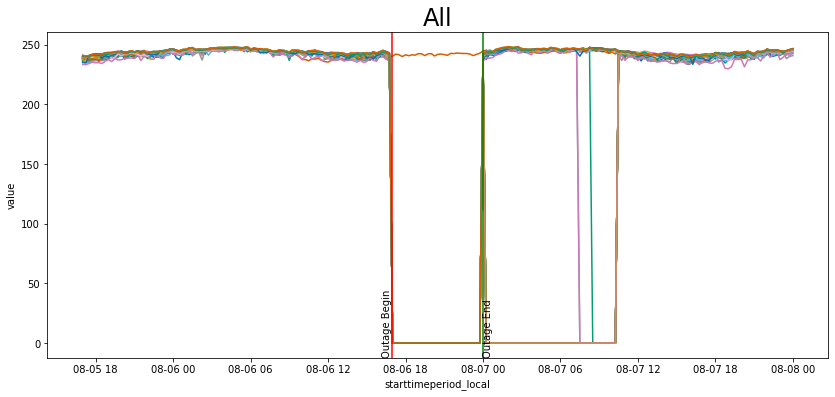

In [101]:
fig, ax = Plot_General.default_subplots(fig_num=fig_num)

palette = Plot_General.get_standard_colors_dict(
    keys=ami_df_i['serialnumber'].unique().tolist(), 
    palette='colorblind'
)

#-------------------------
i_subplot=0
fig, ax = AMINonVee.plot_usage_around_outage(
    fig=fig, 
    ax=ax, 
    data=ami_df_i, 
    x='starttimeperiod_local', 
    y='value', 
    hue='serialnumber', 
    out_t_beg=dovs_outg_t_beg, 
    out_t_end=dovs_outg_t_end, 
    expand_time=pd.Timedelta('120 hours'), 
    plot_time_beg_end=[dovs_outg_t_beg, dovs_outg_t_end], 
    data_label='', 
    title_args=dict(label='All', fontdict=dict(fontsize=24)), 
    ax_args=None, 
    xlabel_args=None, 
    ylabel_args=None, 
    df_mean=None, 
    df_mean_col=None, 
    mean_args=None, 
    draw_outage_limits=True, 
    include_outage_limits_text=True, 
    draw_without_hue_also=False, 
    seg_line_freq=None, 
    palette=palette
)
ax.legend().set_visible(False)

fig_num+=1

In [102]:
ami_df_i.shape

(14140, 19)

In [103]:
# Estimate the outage times
pct_SNs_required_for_outage=0
est_outg_times = estimate_outage_times(
    df=ami_df_i, 
    t_search_min_max=None, 
    pct_SNs_required_for_outage=pct_SNs_required_for_outage, 
    relax_pct_SNs_required_if_no_outgs_found=True, 
    time_col='starttimeperiod_local', 
    value_col='value', 
    verbose=True
)
print(est_outg_times)

[{'cnsrvtv_t_beg': Timestamp('2023-08-06 16:45:00'), 'zero_t_beg': Timestamp('2023-08-06 17:00:00'), 'zero_t_end': Timestamp('2023-08-06 23:45:00'), 'cnsrvtv_t_end': Timestamp('2023-08-07 00:00:00')}, {'cnsrvtv_t_beg': Timestamp('2023-08-07 00:00:00'), 'zero_t_beg': Timestamp('2023-08-07 00:15:00'), 'zero_t_end': Timestamp('2023-08-07 10:15:00'), 'cnsrvtv_t_end': Timestamp('2023-08-07 10:30:00')}]


In [104]:
ci_NEW, cmi_NEW = calculate_ci_cmi_w_ami_w_ede_help(
    df=ami_df_i, 
    ede_df=None, 
    dovs_outg_t_beg_end=dovs_outg_t_beg_end, 
    expand_outg_search_time=pd.Timedelta('1 hour'), 
    conservative_estimate=True, 
    return_CI_SNs=False, 
    use_est_outg_times=False, 
    pct_SNs_required_for_outage_est=0, 
#     expand_outg_est_search_time=pd.Timedelta('1 hour'), 
    expand_outg_est_search_time=pd.Timedelta('12 hours'), 
    use_only_overall_endpoints_of_est_outg_times=False, 
    time_col='starttimeperiod_local', 
    value_col='value', 
    SN_col='serialnumber', 
)



Expanding search window to include ending of last outage
SN = 996246442
	Org = 2023-08-07 01:00:00
	New = 2023-08-07 10:30:00


Expanding search window to include ending of last outage
SN = 996246443
	Org = 2023-08-07 01:00:00
	New = 2023-08-07 10:30:00


Expanding search window to include ending of last outage
SN = 996247362
	Org = 2023-08-07 01:00:00
	New = 2023-08-07 10:30:00


Expanding search window to include ending of last outage
SN = 996247363
	Org = 2023-08-07 01:00:00
	New = 2023-08-07 10:30:00


Expanding search window to include ending of last outage
SN = 996247416
	Org = 2023-08-07 01:00:00
	New = 2023-08-07 10:30:00


Expanding search window to include ending of last outage
SN = 996247417
	Org = 2023-08-07 01:00:00
	New = 2023-08-07 10:30:00


Expanding search window to include ending of last outage
SN = 996247418
	Org = 2023-08-07 01:00:00
	New = 2023-08-07 10:30:00


Expanding search window to include ending of last outage
SN = 996247419
	Org = 2023-08-07 01:00:00
	Ne

In [105]:
print('-----'*5+'\nDOVS\n'+'-----'*2)
print(f'CI  = {ci_dovs}')
print(f'CMI = {cmi_dovs}')

print('-----'*5+'\nAMI using new method\n'+'-----'*2)
print(f'CI  = {ci_NEW}')
print(f'CMI = {cmi_NEW}')

-------------------------
DOVS
----------
CI  = 64
CMI = 27008.0
-------------------------
AMI using new method
----------
CI  = 63
CMI = 46116.0


In [106]:
cnsrvtv_out_t_beg = np.min([x['cnsrvtv_t_beg'] for x in est_outg_times]+[dovs_outg_t_beg])
cnsrvtv_out_t_end = np.max([x['cnsrvtv_t_end'] for x in est_outg_times]+[dovs_outg_t_end])

In [107]:
# End events only
SN_col='serialnumber'
valuesinterval_col='valuesinterval_local' 
edetypeid_col='enddeviceeventtypeid'
#-------------------------
CMIs = []
ede_est_outg_times=dict()
for SN_ij in ede_df_i[SN_col].unique().tolist():
#     print(SN_ij)
    ede_df_ij = ede_df_i[ede_df_i[SN_col]==SN_ij]
    cmi_i, est_outg_times_i = estimate_cmi_using_ede_for_meter(
        ede_df_i=ede_df_ij, 
        broad_out_t_beg=cnsrvtv_out_t_beg, 
        broad_out_t_end=cnsrvtv_out_t_end, 
        expand_search_time=pd.Timedelta('1 hour'), 

        pd_ids=['3.26.0.47', '3.26.136.47'], 
        pu_ids=['3.26.0.216', '3.26.136.216'], 

        SN_col='serialnumber', 
        valuesinterval_col='valuesinterval_local', 
        edetypeid_col='enddeviceeventtypeid', 
        return_est_outage_times=True
    )
    CMIs.append(cmi_i)
    assert(SN_ij not in ede_est_outg_times.keys())
    ede_est_outg_times[SN_ij] = est_outg_times_i
tot_CMI = np.sum(CMIs)
tot_CMI = tot_CMI.total_seconds()/60
cmi_ede = tot_CMI
ci_ede = len([x for x in CMIs if x!=pd.Timedelta(0)])
print(f'CMI DOVS: {cmi_dovs}')
print(f'CMI EDE:  {tot_CMI}')
print(f'Delta:    {cmi_dovs-tot_CMI}')

CMI DOVS: 27008.0
CMI EDE:  46932.36666666667
Delta:    -19924.36666666667


In [108]:
print('-----'*5+'\nDOVS\n'+'-----'*2)
print(f'CI  = {ci_dovs}')
print(f'CMI = {cmi_dovs}')

print('-----'*5+'\nAMI using new method\n'+'-----'*2)
print(f'CI  = {ci_NEW}')
print(f'CMI = {cmi_NEW}')

print('-----'*5+'\nEnd Events\n'+'-----'*2)
print(f'CI  = {ci_ede}')
print(f'CMI = {cmi_ede}')

-------------------------
DOVS
----------
CI  = 64
CMI = 27008.0
-------------------------
AMI using new method
----------
CI  = 63
CMI = 46116.0
-------------------------
End Events
----------
CI  = 63
CMI = 46932.36666666667


In [109]:
n_SNs_w_outg_times = 0
for SN_i, outg_times_i in ede_est_outg_times.items():
    print(f'SN = {SN_i}')
    print(f'n_outg_times = {len(outg_times_i)}')
    if len(outg_times_i)>0:
        n_SNs_w_outg_times+=1
    for time_i in outg_times_i:
        print(f'{time_i[0]} -- {time_i[1]}')
    print()

SN = 996247779
n_outg_times = 2
2023-08-06 16:58:29 -- 2023-08-07 00:06:12
2023-08-07 00:12:36 -- 2023-08-07 10:37:37

SN = 793602243
n_outg_times = 1
2023-08-06 16:58:30 -- 2023-08-07 00:06:49

SN = 996245841
n_outg_times = 2
2023-08-06 16:58:31 -- 2023-08-07 00:06:13
2023-08-07 00:12:38 -- 2023-08-07 10:37:37

SN = 996247419
n_outg_times = 2
2023-08-06 16:58:28 -- 2023-08-07 00:06:12
2023-08-07 00:12:36 -- 2023-08-07 10:37:37

SN = 790228499
n_outg_times = 1
2023-08-06 16:58:30 -- 2023-08-07 00:07:10

SN = 790228474
n_outg_times = 1
2023-08-06 16:58:29 -- 2023-08-07 00:06:30

SN = 794578948
n_outg_times = 2
2023-08-06 16:58:30 -- 2023-08-07 00:06:57
2023-08-07 00:12:37 -- 2023-08-07 10:38:26

SN = 996245863
n_outg_times = 2
2023-08-06 16:58:29 -- 2023-08-07 00:06:12
2023-08-07 00:12:36 -- 2023-08-07 10:37:37

SN = 795963146
n_outg_times = 2
2023-08-06 16:58:30 -- 2023-08-07 00:06:26
2023-08-07 00:12:37 -- 2023-08-07 10:37:59

SN = 790228498
n_outg_times = 1
2023-08-06 16:58:29 -- 202

In [110]:
ede_df_i.sort_values(by=['valuesinterval_local'])

,valuesinterval_local,reason,serialnumber,aep_premise_nb,enddeviceeventtypeid,event_type,OUTG_REC_NB_GPD_FOR_SQL,trsf_pole_nb_GPD_FOR_SQL
1034,2023-08-05 22:08:39,Primary Power Down,996247361,022591586,3.26.0.47,3,13531467,37790275C00069
183,2023-08-05 22:09:00,Primary Power Up,996247361,022591586,3.26.0.216,3,13531467,37790275C00069
586,2023-08-05 22:09:31,NIC Power Restore Trap Received from device,996247361,022591586,3.26.136.216,3,13531467,37790275C00069
1644,2023-08-06 05:57:34,NIC Power Restore Trap Received from device,996247778,026291586,3.26.136.216,3,13531467,37790275C00068
1478,2023-08-06 16:58:28,Primary Power Down,996245888,021991586,3.26.0.47,3,13531467,37790251D00230
...,...,...,...,...,...,...,...,...
223,2023-08-07 10:38:50,NIC Power Restore Trap Received from device,996246441,022988588,3.26.136.216,3,13531467,37790276A00136
1291,2023-08-07 10:39:52,Primary Power Up,790228443,029391586,3.26.0.216,3,13531467,37790275C00069
322,2023-08-07 12:40:45,NIC Power Restore Trap Received from device,996247778,026291586,3.26.136.216,3,13531467,37790275C00068
246,2023-08-07 12:45:58,NIC Power Restore Trap Received from device,996247361,022591586,3.26.136.216,3,13531467,37790275C00069


In [111]:
ede_df_i.sort_values(by=['valuesinterval_local']).iloc[70:90]

,valuesinterval_local,reason,serialnumber,aep_premise_nb,enddeviceeventtypeid,event_type,OUTG_REC_NB_GPD_FOR_SQL,trsf_pole_nb_GPD_FOR_SQL
613,2023-08-06 16:58:51,"Last Gasp - NIC power lost for device, Fail Re...",794578948,029912586,3.26.136.47,3,13531467,37790276A00136
1321,2023-08-06 16:58:51,"Last Gasp - NIC power lost for device, Fail Re...",996245862,022115063,3.26.136.47,3,13531467,37790251D00230
745,2023-08-06 16:58:51,"Last Gasp - NIC power lost for device, Fail Re...",790228497,029645507,3.26.136.47,3,13531467,37790251D46029
482,2023-08-06 16:58:51,"Last Gasp - NIC power lost for device, Fail Re...",996247779,029110097,3.26.136.47,3,13531467,37790252B20183
1455,2023-08-06 16:58:51,"Last Gasp - NIC power lost for device, Fail Re...",996247820,024781586,3.26.136.47,3,13531467,37790251D00167
759,2023-08-06 16:58:51,"Last Gasp - NIC power lost for device, Fail Re...",996247776,020507529,3.26.136.47,3,13531467,37790251D00004
1480,2023-08-06 16:58:51,"Last Gasp - NIC power lost for device, Fail Re...",996246443,023712586,3.26.136.47,3,13531467,37790276A00136
959,2023-08-06 16:58:51,"Last Gasp - NIC power lost for device, Fail Re...",996247792,021371586,3.26.136.47,3,13531467,37790251D00171
1559,2023-08-06 16:58:51,"Last Gasp - NIC power lost for device, Fail Re...",793602243,024444625,3.26.136.47,3,13531467,37790251D00170
1731,2023-08-06 16:58:51,"Last Gasp - NIC power lost for device, Fail Re...",790228474,029761586,3.26.136.47,3,13531467,37790251D00130


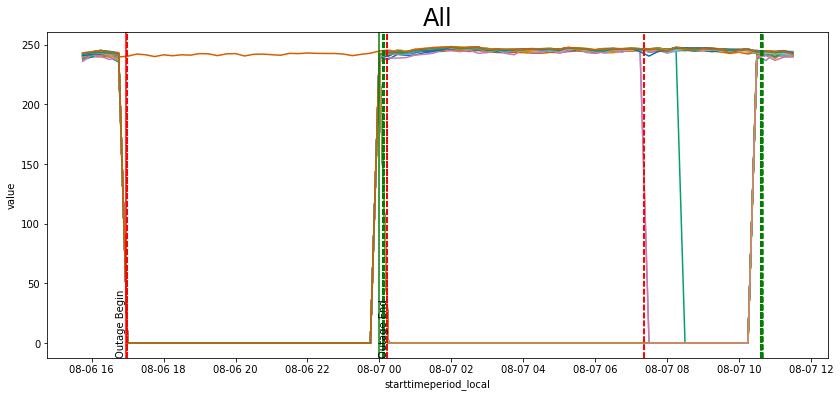

In [112]:
# DRAWING ALL ede_est_outg_times!
fig, ax = Plot_General.default_subplots(fig_num=fig_num)

palette = Plot_General.get_standard_colors_dict(
    keys=ami_df_i['serialnumber'].unique().tolist(), 
    palette='colorblind'
)

#-------------------------
fig, ax = AMINonVee.plot_usage_around_outage(
    fig=fig, 
    ax=ax, 
    data=ami_df_i, 
    x='starttimeperiod_local', 
    y='value', 
    hue='serialnumber', 
    out_t_beg=dovs_outg_t_beg, 
    out_t_end=dovs_outg_t_end, 
    expand_time=pd.Timedelta('1 hour'), 
    plot_time_beg_end=[cnsrvtv_out_t_beg, cnsrvtv_out_t_end], 
    data_label='', 
    title_args=dict(label='All', fontdict=dict(fontsize=24)), 
    ax_args=None, 
    xlabel_args=None, 
    ylabel_args=None, 
    df_mean=None, 
    df_mean_col=None, 
    mean_args=None, 
    draw_outage_limits=True, 
    include_outage_limits_text=True, 
    draw_without_hue_also=False, 
    seg_line_freq=None, 
    palette=palette
)
ax.legend().set_visible(False)
add_est_outg_times_to_axis(
    ax, 
    list(itertools.chain.from_iterable(list(ede_est_outg_times.values()))), 
    include='both', 
    include_outage_limits_text=False
)

fig_num+=1

In [113]:
dovs_outg_t_beg_end

[Timestamp('2023-08-06 16:58:00'), Timestamp('2023-08-07 00:00:00')]

In [114]:
ede_est_outg_times

{'996247779': [(Timestamp('2023-08-06 16:58:29'),
   Timestamp('2023-08-07 00:06:12')),
  (Timestamp('2023-08-07 00:12:36'), Timestamp('2023-08-07 10:37:37'))],
 '793602243': [(Timestamp('2023-08-06 16:58:30'),
   Timestamp('2023-08-07 00:06:49'))],
 '996245841': [(Timestamp('2023-08-06 16:58:31'),
   Timestamp('2023-08-07 00:06:13')),
  (Timestamp('2023-08-07 00:12:38'), Timestamp('2023-08-07 10:37:37'))],
 '996247419': [(Timestamp('2023-08-06 16:58:28'),
   Timestamp('2023-08-07 00:06:12')),
  (Timestamp('2023-08-07 00:12:36'), Timestamp('2023-08-07 10:37:37'))],
 '790228499': [(Timestamp('2023-08-06 16:58:30'),
   Timestamp('2023-08-07 00:07:10'))],
 '790228474': [(Timestamp('2023-08-06 16:58:29'),
   Timestamp('2023-08-07 00:06:30'))],
 '794578948': [(Timestamp('2023-08-06 16:58:30'),
   Timestamp('2023-08-07 00:06:57')),
  (Timestamp('2023-08-07 00:12:37'), Timestamp('2023-08-07 10:38:26'))],
 '996245863': [(Timestamp('2023-08-06 16:58:29'),
   Timestamp('2023-08-07 00:06:12')),
 

In [115]:
ede_df_i.sort_values(by=['valuesinterval_local']).tail(10)

,valuesinterval_local,reason,serialnumber,aep_premise_nb,enddeviceeventtypeid,event_type,OUTG_REC_NB_GPD_FOR_SQL,trsf_pole_nb_GPD_FOR_SQL
54,2023-08-07 10:38:41,NIC Power Restore Trap Received from device,794578950,025222586,3.26.136.216,3,13531467,37790276A00093
585,2023-08-07 10:38:42,NIC Power Restore Trap Received from device,996246442,022122586,3.26.136.216,3,13531467,37790276A00093
790,2023-08-07 10:38:43,NIC Power Restore Trap Received from device,996245890,028791586,3.26.136.216,3,13531467,37790251D00231
505,2023-08-07 10:38:45,Primary Power Up,793602216,027722586,3.26.0.216,3,13531467,37790276A00089
74,2023-08-07 10:38:47,NIC Power Restore Trap Received from device,794578948,029912586,3.26.136.216,3,13531467,37790276A00136
223,2023-08-07 10:38:50,NIC Power Restore Trap Received from device,996246441,022988588,3.26.136.216,3,13531467,37790276A00136
1291,2023-08-07 10:39:52,Primary Power Up,790228443,029391586,3.26.0.216,3,13531467,37790275C00069
322,2023-08-07 12:40:45,NIC Power Restore Trap Received from device,996247778,026291586,3.26.136.216,3,13531467,37790275C00068
246,2023-08-07 12:45:58,NIC Power Restore Trap Received from device,996247361,022591586,3.26.136.216,3,13531467,37790275C00069
653,2023-08-07 12:45:58,NIC Power Restore Trap Received from device,790228443,029391586,3.26.136.216,3,13531467,37790275C00069


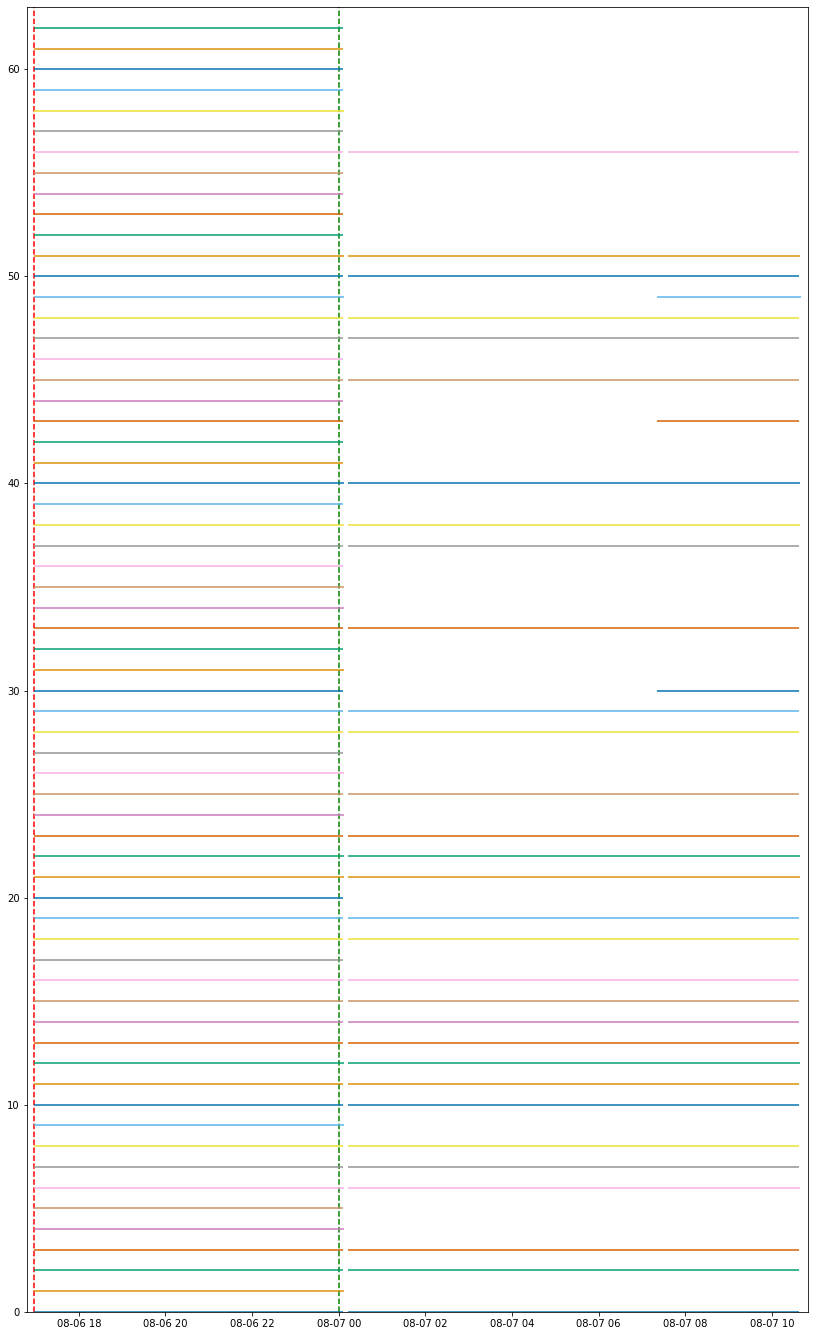

In [116]:
all_outg_times_beg = []
all_outg_times_end = []
for SN_i, outg_times_i in ede_est_outg_times.items():
    for time_i in outg_times_i:
        all_outg_times_beg.append(time_i[0])
        all_outg_times_end.append(time_i[1])
min_outg_time = np.min(all_outg_times_beg)
max_outg_time = np.max(all_outg_times_end)
#-----
min_outg_time = np.min([min_outg_time, dovs_outg_t_beg])
max_outg_time = np.max([max_outg_time, dovs_outg_t_end])
#-----
min_outg_time -= pd.Timedelta('10 minutes')
max_outg_time += pd.Timedelta('10 minutes')
#-------------------------
fig,ax = Plot_General.default_subplots(  
    fig_num=fig_num, 
    unit_figsize_width=14,
    unit_figsize_height=24
)
ax.set_xlim(min_outg_time, max_outg_time);
ax.set_ylim(0, n_SNs_w_outg_times);
#-----
ax.axvline(dovs_outg_t_beg, color='red', linestyle='--')
ax.axvline(dovs_outg_t_end, color='green', linestyle='--')
#-------------------------
colors = Plot_General.get_standard_colors(n_colors=10, palette='colorblind')
#-------------------------
counter = 0
for SN_i, outg_times_i in ede_est_outg_times.items():
    if len(outg_times_i)>0:
        for time_i in outg_times_i:
            ax.hlines(y=counter, xmin=time_i[0], xmax=time_i[1], color=colors[counter % len(colors)], linestyle='-')
        counter += 1
        
fig_num+=1

In [117]:
res_dict = calculate_ci_cmi_w_ami_w_ede_help(
    df=ami_df_i, 
    ede_df=ede_df_i, 
    dovs_outg_t_beg_end=dovs_outg_t_beg_end, 
    expand_outg_search_time=pd.Timedelta('1 hour'), 
    conservative_estimate=True, 
    est_ede_kwargs=None, 
    audit_selection_method='ede only', 
    return_CI_SNs=False, 
    use_est_outg_times=True, 
    pct_SNs_required_for_outage_est=0, 
#     expand_outg_est_search_time=pd.Timedelta('1 hour'), 
    expand_outg_est_search_time=pd.Timedelta('12 hours'), 
    use_only_overall_endpoints_of_est_outg_times=False, 
    time_col='starttimeperiod_local', 
    value_col='value', 
    SN_col='serialnumber', 
    return_all_best_ests=True, 
    return_all_best_ests_type='pd.DataFrame'
)
#-----
ci_ami       = res_dict['CI']
cmi_ami      = res_dict['CMI']
best_ests_df = res_dict['all_best_ests']

In [118]:
print(f'ci_ami  = {ci_ami}')
print(f'cmi_ami = {cmi_ami}')

ci_ami  = 63
cmi_ami = 46206.85


In [119]:
best_ests_df

,SN,PN,i_outg,ede_min,ede_max,dovs_min,dovs_max,conservative_min,conservative_max,zero_times_min,zero_times_max,winner_min,winner_max
0,790228441,026630329,0,2023-08-06 16:58:31,None,2023-08-06 16:58:00,None,2023-08-06 16:45:00,2023-08-07 00:00:00,2023-08-06 17:00:00,2023-08-06 23:45:00,2023-08-06 16:58:31,2023-08-07 00:00:00
1,790228442,029302270,0,2023-08-06 16:58:29,None,2023-08-06 16:58:00,None,2023-08-06 16:45:00,2023-08-07 00:00:00,2023-08-06 17:00:00,2023-08-06 23:45:00,2023-08-06 16:58:29,2023-08-07 00:00:00
2,996246442,022122586,0,2023-08-06 16:58:29,None,2023-08-06 16:58:00,None,2023-08-06 16:45:00,2023-08-07 00:00:00,2023-08-06 17:00:00,2023-08-06 23:45:00,2023-08-06 16:58:29,2023-08-07 00:00:00
3,996246442,022122586,1,2023-08-07 00:12:37,None,None,None,2023-08-07 00:00:00,2023-08-07 10:30:00,2023-08-07 00:15:00,2023-08-07 10:15:00,2023-08-07 00:12:37,2023-08-07 10:30:00
4,996246443,023712586,0,2023-08-06 16:58:28,None,2023-08-06 16:58:00,None,2023-08-06 16:45:00,2023-08-07 00:00:00,2023-08-06 17:00:00,2023-08-06 23:45:00,2023-08-06 16:58:28,2023-08-07 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,996245889,020302586,0,2023-08-06 16:58:29,None,2023-08-06 16:58:00,None,2023-08-06 16:45:00,2023-08-07 00:00:00,2023-08-06 17:00:00,2023-08-06 23:45:00,2023-08-06 16:58:29,2023-08-07 00:00:00
93,996245889,020302586,1,2023-08-07 00:12:37,None,None,None,2023-08-07 00:00:00,2023-08-07 10:30:00,2023-08-07 00:15:00,2023-08-07 10:15:00,2023-08-07 00:12:37,2023-08-07 10:30:00
94,996247823,023191586,0,2023-08-06 16:58:29,None,2023-08-06 16:58:00,None,2023-08-06 16:45:00,2023-08-07 00:00:00,2023-08-06 17:00:00,2023-08-06 23:45:00,2023-08-06 16:58:29,2023-08-07 00:00:00
95,790228443,029391586,0,2023-08-06 16:58:30,None,2023-08-06 16:58:00,None,2023-08-06 16:45:00,2023-08-07 00:00:00,2023-08-06 17:00:00,2023-08-06 23:45:00,2023-08-06 16:58:30,2023-08-07 00:00:00


In [120]:
best_ests_df['SN'].nunique()

63

In [121]:
best_ests_df['PN'].nunique()

63

In [122]:
if calculate_by_PN and best_ests_df.shape[0]>0:
    best_ests_df = combine_PNs_in_best_ests_df(
        best_ests_df, 
        likeness_thresh = pd.Timedelta('15 minutes'), 
        SN_col = 'SN', 
        PN_col = 'PN', 
        i_outg_col = 'i_outg'     
    )
    ci_ami  = best_ests_df['PN'].nunique()
    cmi_ami = (best_ests_df['winner_max']-best_ests_df['winner_min']).sum().total_seconds()/60

In [123]:
print(f'ci_ami  = {ci_ami}')
print(f'cmi_ami = {cmi_ami}')

ci_ami  = 63
cmi_ami = 46206.85


In [124]:
if best_ests_df.shape[0]>0:
    best_ests_df_dovs_beg = alter_best_ests_df_using_dovs_outg_t_beg(
        best_ests_df=best_ests_df,
        dovs_df=dovs_df_i, 
        outg_rec_nb=outg_rec_nb
    )
    if calculate_by_PN:
        ci_ami_dovs_beg  = best_ests_df_dovs_beg['PN'].nunique()
    else:
        ci_ami_dovs_beg  = best_ests_df_dovs_beg['SN'].nunique()
    cmi_ami_dovs_beg = (best_ests_df_dovs_beg['winner_max']-best_ests_df_dovs_beg['winner_min']).sum().total_seconds()/60
else:
    best_ests_df_dovs_beg = best_ests_df.copy()
    ci_ami_dovs_beg = ci_ami
    cmi_ami_dovs_beg = cmi_ami

In [125]:
print(f'ci_ami_dovs_beg  = {ci_ami_dovs_beg}')
print(f'cmi_ami_dovs_beg = {cmi_ami_dovs_beg}')

ci_ami_dovs_beg  = 63
cmi_ami_dovs_beg = 46206.85


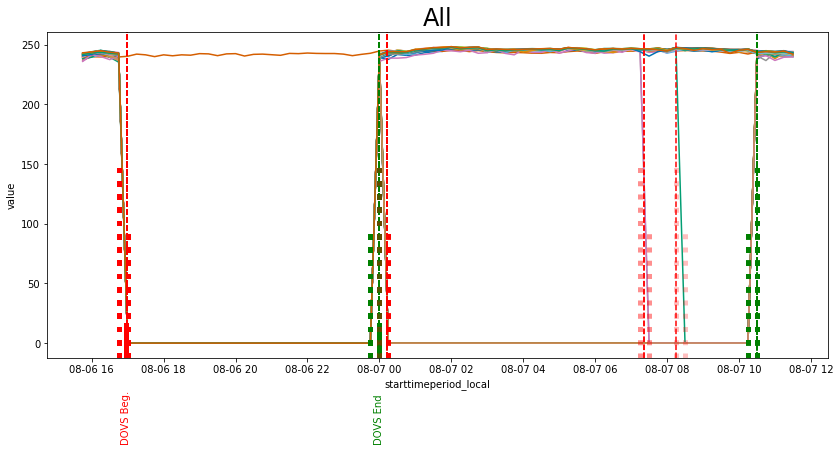

In [126]:
# DRAWING ALL ESTIMATES
fig, ax = Plot_General.default_subplots(fig_num=fig_num)

palette = Plot_General.get_standard_colors_dict(
    keys=ami_df_i['serialnumber'].unique().tolist(), 
    palette='colorblind'
)

#-------------------------
i_subplot=0
fig, ax = AMINonVee.plot_usage_around_outage(
    fig=fig, 
    ax=ax, 
    data=ami_df_i, 
    x='starttimeperiod_local', 
    y='value', 
    hue='serialnumber', 
    out_t_beg=dovs_outg_t_beg, 
    out_t_end=dovs_outg_t_end, 
    expand_time=pd.Timedelta('1 hour'), 
    plot_time_beg_end=[cnsrvtv_out_t_beg, cnsrvtv_out_t_end], 
    data_label='', 
    title_args=dict(label='All', fontdict=dict(fontsize=24)), 
    ax_args=None, 
    xlabel_args=None, 
    ylabel_args=None, 
    df_mean=None, 
    df_mean_col=None, 
    mean_args=None, 
    draw_outage_limits=True, 
    draw_outage_limits_kwargs=dict(alpha=1.0, linewidth=5.0, ymax=0.1), 
    include_outage_limits_text=dict(
        out_t_beg_text='DOVS Beg.', 
        out_t_beg_ypos=(-0.1, 'ax_coord'), 
        out_t_beg_va='top', 
        out_t_beg_ha='center', 
        out_t_beg_color='red', 
        #-----
        out_t_end_text='DOVS End ', 
        out_t_end_ypos=(-0.1, 'ax_coord'), 
        out_t_end_va='top', 
        out_t_end_ha='center', 
        out_t_end_color='green', 
    ), 
    draw_without_hue_also=False, 
    seg_line_freq=None, 
    palette=palette
)
ax.legend().set_visible(False)
add_all_best_ests_to_axis(
    ax, 
    best_ests_df, 
    line_kwargs_by_est_key=dict(
        conservative=dict(alpha=0.25, linewidth=5.0, ymax=0.6), 
        zero_times=dict(alpha=0.25, linewidth=5.0, ymax=0.4) 
    ), 
    keys_to_include=['winner', 'conservative', 'zero_times']
)

fig_num+=1

In [127]:
eps_min=5
min_samples=2
ests_to_include_in_clustering = ['winner_min', 'winner_max']
ests_to_include_in_output = ['winner_min', 'winner_max', 'conservative_min', 'conservative_max', 'zero_times_min', 'zero_times_max']

In [128]:
if best_ests_df.shape[0]>0:
    means_df, best_ests_df_w_db_lbl = get_mean_times_w_dbscan(
        best_ests_df, 
        eps_min=5, 
        min_samples=2, 
        ests_to_include_in_clustering=['winner_min', 'winner_max'],
        ests_to_include_in_output=[
            'winner_min', 'winner_max', 
            'conservative_min', 'conservative_max', 
            'zero_times_min', 'zero_times_max'
        ], 
        return_labelled_best_ests_df=True
    )
else:
    means_df, best_ests_df_w_db_lbl = None, None

In [129]:
if best_ests_df_dovs_beg.shape[0]>0:
    means_df_dovs_beg, best_ests_df_dovs_beg_w_db_lbl = get_mean_times_w_dbscan(
        best_ests_df_dovs_beg, 
        eps_min=5, 
        min_samples=2, 
        ests_to_include_in_clustering=['winner_min', 'winner_max'],
        ests_to_include_in_output=[
            'winner_min', 'winner_max', 
            'conservative_min', 'conservative_max', 
            'zero_times_min', 'zero_times_max'
        ], 
        return_labelled_best_ests_df=True
    )
else:
    means_df_dovs_beg, best_ests_df_dovs_beg_w_db_lbl = None, None

In [130]:
summary_df_i = build_detailed_summary_df(
    means_df=means_df, 
    best_ests_df_w_db_lbl=best_ests_df_w_db_lbl,
    CI_tot=ci_ami, 
    CMI_tot=cmi_ami, 
    n_PNs_ami=n_PNs, 
    outg_rec_nb=outg_rec_nb, 
    dovs_df_i=dovs_df_i,
    db_label_col='db_label', 
    winner_min_col='winner_min', 
    winner_max_col='winner_max', 
    PN_col='PN' if calculate_by_PN else 'SN', 
    i_outg_col='i_outg'
)
summary_df_i

DT_OFF_TS_FULL   DT_ON_TS  CI_NB   CMI_NB  \
OUTAGE_NB OUTG_REC_NB                                                  
4626011   13531467    2023-08-06 16:58:00 2023-08-07     64  27008.0   
          13531467    2023-08-06 16:58:00 2023-08-07     64  27008.0   
          13531467    2023-08-06 16:58:00 2023-08-07     64  27008.0   
          13531467    2023-08-06 16:58:00 2023-08-07     64  27008.0   
          13531467    2023-08-06 16:58:00 2023-08-07     64  27008.0   

                      MJR_CAUSE_CD MNR_CAUSE_CD      DVC_TYP_NM  \
OUTAGE_NB OUTG_REC_NB                                             
4626011   13531467              DL           WU  OCRs RECLOSERS   
          13531467              DL           WU  OCRs RECLOSERS   
          13531467              DL           WU  OCRs RECLOSERS   
          13531467              DL           WU  OCRs RECLOSERS   
          13531467              DL           WU  OCRs RECLOSERS   

                      OPERATING_UNIT_ID  n_PNs_DOVS Outage Subset  \
OUTAGE_NB OUTG_REC_NB                                               
4626011   13531467                    1          64   Full Outage   
          13531467                    1          64  Sub-outage 1   
          13531467                    1          64  Sub-outage 2   
          13531467                    1          64  Sub-outage 3   
          13531467                    1          64  Sub-outage 4   

                                outg_i_beg           outg_i_end  CI_i  \
OUTAGE_NB OUTG_REC_NB                                                   
4626011   13531467     2023-08-06 16:58:29  2023-08-07 10:30:00    63   
          13531467     2023-08-06 16:58:29  2023-08-07 00:00:00    63   
          13531467     2023-08-07 00:12:36  2023-08-07 10:30:00    31   
          13531467     2023-08-07 07:21:08  2023-08-07 10:30:00     2   
          13531467     2023-08-07 08:15:00  2023-08-07 10:30:00     1   

                              CMI_i  n_PNs_ami  pct_PNs_found  
OUTAGE_NB OUTG_REC_NB                                          
4626011   13531467     46206.850000         64          100.0  
          13531467     26554.966667         64          100.0  
          13531467     19139.166667         64          100.0  
          13531467       377.716667         64          100.0  
          13531467       135.000000         64          100.0

# BEG DEL

In [131]:
means_df

,winner_min,winner_max,conservative_min,conservative_max,zero_times_min,zero_times_max
db_label,,,,,,
0,2023-08-06 16:58:29.555555584,2023-08-07 00:00:00.000000000,2023-08-06 16:45:00,2023-08-07 00:00:00.000000000,2023-08-06 17:00:00.000000256,2023-08-06 23:45:00
1,2023-08-07 00:12:36.451612928,2023-08-07 10:30:00.000000256,2023-08-07 00:00:00,2023-08-07 10:30:00.000000256,2023-08-07 00:15:00.000000000,2023-08-07 10:15:00
2,2023-08-07 07:21:08.500000000,2023-08-07 10:30:00.000000000,2023-08-07 07:15:00,2023-08-07 10:30:00.000000000,2023-08-07 07:30:00.000000000,2023-08-07 10:15:00
Unclustered 0,2023-08-07 08:15:00.000000000,2023-08-07 10:30:00.000000000,2023-08-07 08:15:00,2023-08-07 10:30:00.000000000,2023-08-07 08:30:00.000000000,2023-08-07 10:15:00


In [132]:
best_ests_df

,PN,i_outg,ede_min,ede_max,dovs_min,dovs_max,conservative_min,conservative_max,zero_times_min,zero_times_max,winner_min,winner_max
0,020091586,0,2023-08-06 16:58:29,NaT,2023-08-06 16:58:00,NaT,2023-08-06 16:45:00,2023-08-07 00:00:00,2023-08-06 17:00:00,2023-08-06 23:45:00,2023-08-06 16:58:29,2023-08-07 00:00:00
1,020302586,0,2023-08-06 16:58:29,NaT,2023-08-06 16:58:00,NaT,2023-08-06 16:45:00,2023-08-07 00:00:00,2023-08-06 17:00:00,2023-08-06 23:45:00,2023-08-06 16:58:29,2023-08-07 00:00:00
2,020302586,1,2023-08-07 00:12:37,NaT,NaT,NaT,2023-08-07 00:00:00,2023-08-07 10:30:00,2023-08-07 00:15:00,2023-08-07 10:15:00,2023-08-07 00:12:37,2023-08-07 10:30:00
3,020507529,0,2023-08-06 16:58:29,NaT,2023-08-06 16:58:00,NaT,2023-08-06 16:45:00,2023-08-07 00:00:00,2023-08-06 17:00:00,2023-08-06 23:45:00,2023-08-06 16:58:29,2023-08-07 00:00:00
4,020612586,0,2023-08-06 16:58:30,NaT,2023-08-06 16:58:00,NaT,2023-08-06 16:45:00,2023-08-07 00:00:00,2023-08-06 17:00:00,2023-08-06 23:45:00,2023-08-06 16:58:30,2023-08-07 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
92,029788588,0,2023-08-06 16:58:30,NaT,2023-08-06 16:58:00,NaT,2023-08-06 16:45:00,2023-08-07 00:00:00,2023-08-06 17:00:00,2023-08-06 23:45:00,2023-08-06 16:58:30,2023-08-07 00:00:00
93,029788588,1,2023-08-07 00:12:36,NaT,NaT,NaT,2023-08-07 00:00:00,2023-08-07 10:30:00,2023-08-07 00:15:00,2023-08-07 10:15:00,2023-08-07 00:12:36,2023-08-07 10:30:00
94,029789722,0,2023-08-06 16:58:29,NaT,2023-08-06 16:58:00,NaT,2023-08-06 16:45:00,2023-08-07 00:00:00,2023-08-06 17:00:00,2023-08-06 23:45:00,2023-08-06 16:58:29,2023-08-07 00:00:00
95,029912586,0,2023-08-06 16:58:30,NaT,2023-08-06 16:58:00,NaT,2023-08-06 16:45:00,2023-08-07 00:00:00,2023-08-06 17:00:00,2023-08-06 23:45:00,2023-08-06 16:58:30,2023-08-07 00:00:00


In [133]:
# dovs_df_i_OG = dovs_df_i.copy()

In [134]:
dovs_df_i = dovs_df_i_OG.copy()

In [135]:
dovs_df_i.columns.tolist()

['CI_NB',
 'CMI_NB',
 'OUTAGE_NB',
 'DT_ON_TS',
 'DT_OFF_TS',
 'DT_OFF_TS_FULL',
 'STEP_DRTN_NB',
 'START_YEAR',
 'OPERATING_UNIT_ID',
 'STATE_ABBR_TX',
 'MJR_CAUSE_CD',
 'MNR_CAUSE_CD',
 'LOCATION_ID',
 'GIS_CRCT_NB',
 'OPRTG_UNT_NM',
 'DVC_TYP_NM',
 'SHORT_NM_CLR_DEV',
 'EQUIP_TYP_NM',
 'SHORT_NM_EQP_TYP',
 'MJR_CAUSE_NM',
 'MNR_CAUSE_NM',
 'premise_nbs']

In [136]:
dovs_df_i[['DVC_TYP_NM', 'SHORT_NM_CLR_DEV']]

,DVC_TYP_NM,SHORT_NM_CLR_DEV
OUTG_REC_NB,,
13530363,LINE FUSE,LINE FUSE


In [137]:
isinstance(dovs_df_i, pd.Series)

False

In [138]:
assert(
    isinstance(dovs_df_i, pd.Series) or 
    (isinstance(dovs_df_i, pd.DataFrame) and dovs_df_i.shape[0]==1)
)
#-------------------------
# Make sure OUTG_REC_NB in dovs_df_i agrees with input value safecheck
if isinstance(dovs_df_i, pd.DataFrame):
    if dovs_df_i.index.name=='OUTG_REC_NB':
        assert(dovs_df_i.index[0]==outg_rec_nb)
    else:
        assert('OUTG_REC_NB' in dovs_df_i.columns)
        assert(dovs_df_i.iloc[0]['OUTG_REC_NB']==outg_rec_nb)
else:
    if 'OUTG_REC_NB' in dovs_df_i.index:
        assert(dovs_df_i['OUTG_REC_NB']==outg_rec_nb)
    else:
        assert(dovs_df_i.name==outg_rec_nb)

#-------------------------
# Make dovs_df_i a pd.Series object (if pd.DataFrame, this will collapse to pd.Series, if
#   pd.Series, this will have no effect)
# This isn't necessary, it just eliminate the need to use .loc[0] all over the place
dovs_df_i = dovs_df_i.squeeze()

#-------------------------
# Grab needed entries from DOVS data
dovs_outg_t_beg = dovs_df_i['DT_OFF_TS_FULL']
dovs_outg_t_end = dovs_df_i['DT_ON_TS']
ci_dovs         = dovs_df_i['CI_NB']
cmi_dovs        = dovs_df_i['CMI_NB']
n_PNs_dovs      = len(set(dovs_df_i['premise_nbs']))
outage_nb       = dovs_df_i['OUTAGE_NB']
mjr_cause_cd    = dovs_df_i['MJR_CAUSE_CD']
mnr_cause_cd    = dovs_df_i['MNR_CAUSE_CD']
dvc_typ_nb      = dovs_df_i['DVC_TYP_NM']

AssertionError: 

In [139]:
summary_df_i2 = build_detailed_summary_df(
    means_df=means_df, 
    best_ests_df_w_db_lbl=best_ests_df_w_db_lbl,
    CI_tot=ci_ami, 
    CMI_tot=cmi_ami, 
    n_PNs_ami=n_PNs, 
    outg_rec_nb=outg_rec_nb, 
    dovs_df_i=dovs_df_i, 
    db_label_col='db_label', 
    winner_min_col='winner_min', 
    winner_max_col='winner_max', 
    PN_col='PN' if calculate_by_PN else 'SN', 
    i_outg_col='i_outg'
)
summary_df_i2

AssertionError: 

# END DEL

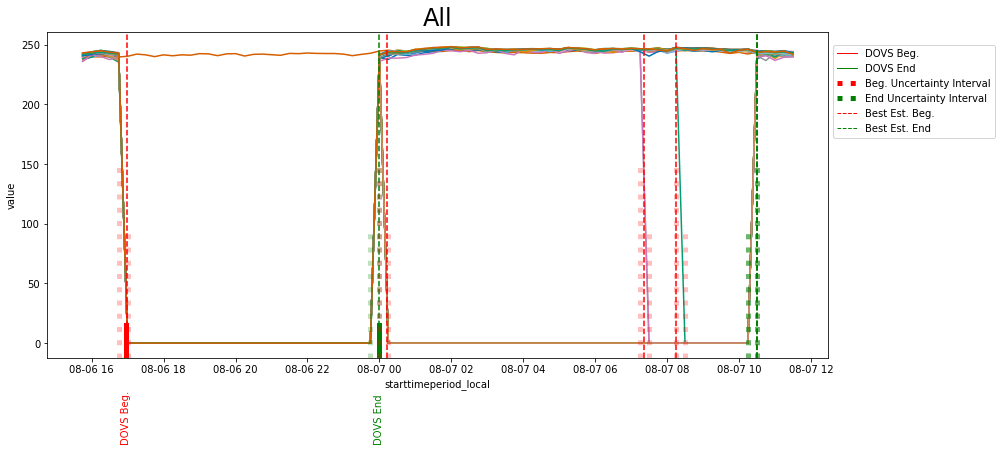

In [140]:
# DRAWING ONLY MEANS
fig, ax = Plot_General.default_subplots(fig_num=fig_num)

palette = Plot_General.get_standard_colors_dict(
    keys=ami_df_i['serialnumber'].unique().tolist(), 
    palette='colorblind'
)

#-------------------------
i_subplot=0
fig, ax = AMINonVee.plot_usage_around_outage(
    fig=fig, 
    ax=ax, 
    data=ami_df_i, 
    x='starttimeperiod_local', 
    y='value', 
    hue='serialnumber', 
    out_t_beg=dovs_outg_t_beg, 
    out_t_end=dovs_outg_t_end, 
    expand_time=pd.Timedelta('1 hour'), 
    plot_time_beg_end=[cnsrvtv_out_t_beg, cnsrvtv_out_t_end], 
    data_label='', 
    title_args=dict(label='All', fontdict=dict(fontsize=24)), 
    ax_args=None, 
    xlabel_args=None, 
    ylabel_args=None, 
    df_mean=None, 
    df_mean_col=None, 
    mean_args=None, 
    draw_outage_limits=True, 
    draw_outage_limits_kwargs=dict(alpha=1.0, linewidth=5.0, ymax=0.1), 
    include_outage_limits_text=dict(
        out_t_beg_text='DOVS Beg.', 
        out_t_beg_ypos=(-0.1, 'ax_coord'), 
        out_t_beg_va='top', 
        out_t_beg_ha='center', 
        out_t_beg_color='red', 
        #-----
        out_t_end_text='DOVS End ', 
        out_t_end_ypos=(-0.1, 'ax_coord'), 
        out_t_end_va='top', 
        out_t_end_ha='center', 
        out_t_end_color='green', 
    ), 
    draw_without_hue_also=False, 
    seg_line_freq=None, 
    palette=palette
)
ax.legend().set_visible(False)
add_all_best_ests_to_axis(
    ax, 
    means_df, 
    line_kwargs_by_est_key=dict(
        conservative=dict(alpha=0.25, linewidth=5.0, ymax=0.6), 
        zero_times=dict(alpha=0.25, linewidth=5.0, ymax=0.4) 
    ), 
    keys_to_include=['winner', 'conservative', 'zero_times']
)

#-------------------------
patch_dovs_beg = Line2D(
    [0], [0], color='red', 
    alpha=1.0, linewidth=1.0, linestyle='-', 
    label='DOVS Beg.'
)
patch_dovs_end = Line2D(
    [0], [0], color='green', 
    alpha=1.0, linewidth=1.0, linestyle='-', 
    label='DOVS End'
)
#-----
patch_ui_beg =  Line2D(
    [0], [0], color='red', 
    alpha=1.0, linewidth=5.0, linestyle=':', 
    label='Beg. Uncertainty Interval'
)
patch_ui_end =  Line2D(
    [0], [0], color='green', 
    alpha=1.0, linewidth=5.0, linestyle=':', 
    label='End Uncertainty Interval'
)
#-----
patch_best_beg =  Line2D(
    [0], [0], color='red', 
    alpha=1.0, linewidth=1.0, linestyle='--', 
    label='Best Est. Beg.'
)
patch_best_end =  Line2D(
    [0], [0], color='green', 
    alpha=1.0, linewidth=1.0, linestyle='--', 
    label='Best Est. End'
)
#-------------------------
leg_1 = ax.legend(
    title=None, 
    handles=[patch_dovs_beg, patch_dovs_end, patch_ui_beg, patch_ui_end, patch_best_beg, patch_best_end], 
    bbox_to_anchor=(1, 0.975), 
    loc='upper left'
)

fig_num+=1

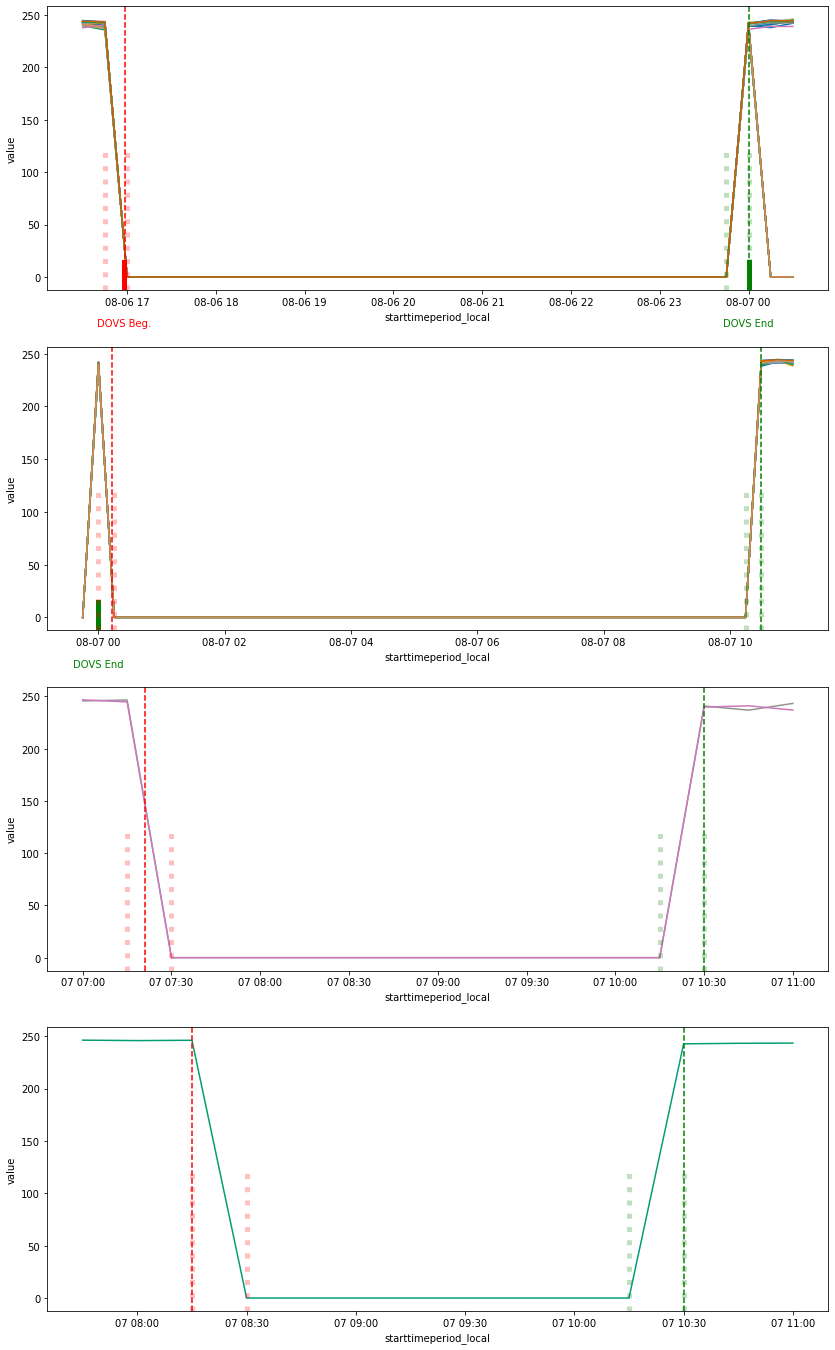

In [141]:
fig, axs = Plot_General.default_subplots(fig_num=fig_num, n_x=1, n_y=means_df.shape[0])
if means_df.shape[0]==1:
    axs = [axs]

palette = Plot_General.get_standard_colors_dict(
    keys=ami_df_i['serialnumber'].unique().tolist(), 
    palette='colorblind'
)

#-------------------------
for i_row in range(means_df.shape[0]):
    db_label = means_df.iloc[i_row].name
    ami_df_i_subset = ami_df_i[ami_df_i['aep_premise_nb'].isin(
        best_ests_df_w_db_lbl[best_ests_df_w_db_lbl['db_label']==db_label]['PN'].tolist()
    )]
    
    fig, axs[i_row] = AMINonVee.plot_usage_around_outage(
        fig=fig, 
        ax=axs[i_row], 
        data=ami_df_i_subset, 
        x='starttimeperiod_local', 
        y='value', 
        hue='serialnumber', 
        out_t_beg=dovs_outg_t_beg, 
        out_t_end=dovs_outg_t_end, 
        expand_time=pd.Timedelta('30 minutes'), 
        plot_time_beg_end=[means_df.iloc[i_row]['winner_min'], means_df.iloc[i_row]['winner_max']], 
        data_label='', 
        title_args=None, 
        ax_args=None, 
        xlabel_args=None, 
        ylabel_args=None, 
        df_mean=None, 
        df_mean_col=None, 
        mean_args=None, 
        draw_outage_limits=True, 
        draw_outage_limits_kwargs=dict(alpha=1.0, linewidth=5.0, ymax=0.1), 
        include_outage_limits_text=dict(
            out_t_beg_text='DOVS Beg.', 
            out_t_beg_ypos=(-0.1, 'ax_coord'), 
            out_t_beg_rot=0, 
            out_t_beg_va='top', 
            out_t_beg_ha='center', 
            out_t_beg_color='red', 
            #-----
            out_t_end_text='DOVS End', 
            out_t_end_ypos=(-0.1, 'ax_coord'), 
            out_t_end_rot=0, 
            out_t_end_va='top', 
            out_t_end_ha='center', 
            out_t_end_color='green', 
        ),
        draw_without_hue_also=False, 
        seg_line_freq=None, 
        palette=palette
    )
    axs[i_row].legend().set_visible(False)
    add_all_best_ests_to_axis(
        axs[i_row], 
        means_df.iloc[[i_row]], 
        line_kwargs_by_est_key=dict(
            conservative=dict(alpha=0.25, linewidth=5.0, ymax=0.5), 
            zero_times=dict(alpha=0.25, linewidth=5.0, ymax=0.5) 
        ), 
        keys_to_include=['winner', 'conservative', 'zero_times']
    )

fig_num+=1

In [142]:
# Sanity (not good check in this instance, but in general, if multiple on/off times, would expect the DF
# to be larger than the number of unique values)
# CHECK THIS IN APPROPRIATE ISNTANCE
print(best_ests_df_w_db_lbl.shape[0])
print(best_ests_df_w_db_lbl['PN'].nunique())

97
63


In [143]:
means_df

,winner_min,winner_max,conservative_min,conservative_max,zero_times_min,zero_times_max
db_label,,,,,,
0,2023-08-06 16:58:29.555555584,2023-08-07 00:00:00.000000000,2023-08-06 16:45:00,2023-08-07 00:00:00.000000000,2023-08-06 17:00:00.000000256,2023-08-06 23:45:00
1,2023-08-07 00:12:36.451612928,2023-08-07 10:30:00.000000256,2023-08-07 00:00:00,2023-08-07 10:30:00.000000256,2023-08-07 00:15:00.000000000,2023-08-07 10:15:00
2,2023-08-07 07:21:08.500000000,2023-08-07 10:30:00.000000000,2023-08-07 07:15:00,2023-08-07 10:30:00.000000000,2023-08-07 07:30:00.000000000,2023-08-07 10:15:00
Unclustered 0,2023-08-07 08:15:00.000000000,2023-08-07 10:30:00.000000000,2023-08-07 08:15:00,2023-08-07 10:30:00.000000000,2023-08-07 08:30:00.000000000,2023-08-07 10:15:00


In [144]:
# FINALS?!

In [145]:
# pdf = PdfPages(r'C:\Users\s346557\Documents\LocalData\dovs_check\Results\Test.pdf')

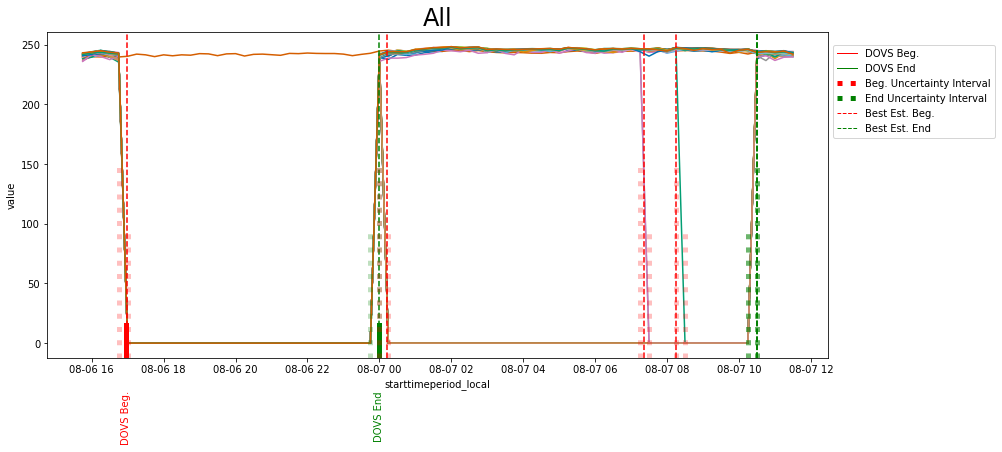

In [146]:
if means_df is not None:
    cnsrvtv_out_t_beg = means_df.min().min()
    cnsrvtv_out_t_end = means_df.max().max()
else:
    cnsrvtv_out_t_beg = dovs_outg_t_beg
    cnsrvtv_out_t_end = dovs_outg_t_end

fig, ax = Plot_General.default_subplots()

palette = Plot_General.get_standard_colors_dict(
    keys=ami_df_i['serialnumber'].unique().tolist(), 
    palette='colorblind'
)

#-------------------------
i_subplot=0
fig, ax = AMINonVee.plot_usage_around_outage(
    fig=fig, 
    ax=ax, 
    data=ami_df_i, 
    x='starttimeperiod_local', 
    y='value', 
    hue='serialnumber', 
    out_t_beg=dovs_outg_t_beg, 
    out_t_end=dovs_outg_t_end, 
    expand_time=pd.Timedelta('1 hour'), 
    plot_time_beg_end=[cnsrvtv_out_t_beg, cnsrvtv_out_t_end], 
    data_label='', 
    title_args=dict(label='All', fontdict=dict(fontsize=24)), 
    ax_args=None, 
    xlabel_args=None, 
    ylabel_args=None, 
    df_mean=None, 
    df_mean_col=None, 
    mean_args=None, 
    draw_outage_limits=True, 
    draw_outage_limits_kwargs=dict(alpha=1.0, linewidth=5.0, ymax=0.1), 
#     include_outage_limits_text=True, 
    include_outage_limits_text=dict(
        out_t_beg_text='DOVS Beg.', 
        out_t_beg_ypos=(-0.1, 'ax_coord'), 
        out_t_beg_va='top', 
        out_t_beg_ha='center', 
        out_t_beg_color='red', 
        #-----
        out_t_end_text='DOVS End', 
        out_t_end_ypos=(-0.1, 'ax_coord'), 
        out_t_end_va='top', 
        out_t_end_ha='center', 
        out_t_end_color='green', 
    ), 
    draw_without_hue_also=False, 
    seg_line_freq=None, 
    palette=palette
)
ax.legend().set_visible(False)
add_all_best_ests_to_axis(
    ax, 
    means_df, 
    line_kwargs_by_est_key=dict(
        conservative=dict(alpha=0.25, linewidth=5.0, ymax=0.6), 
        zero_times=dict(alpha=0.25, linewidth=5.0, ymax=0.4) 
    ), 
    keys_to_include=['winner', 'conservative', 'zero_times']
)

#-------------------------
patch_dovs_beg = Line2D(
    [0], [0], color='red', 
    alpha=1.0, linewidth=1.0, linestyle='-', 
    label='DOVS Beg.'
)
patch_dovs_end = Line2D(
    [0], [0], color='green', 
    alpha=1.0, linewidth=1.0, linestyle='-', 
    label='DOVS End'
)
#-----
patch_ui_beg =  Line2D(
    [0], [0], color='red', 
    alpha=1.0, linewidth=5.0, linestyle=':', 
    label='Beg. Uncertainty Interval'
)
patch_ui_end =  Line2D(
    [0], [0], color='green', 
    alpha=1.0, linewidth=5.0, linestyle=':', 
    label='End Uncertainty Interval'
)
#-----
patch_best_beg =  Line2D(
    [0], [0], color='red', 
    alpha=1.0, linewidth=1.0, linestyle='--', 
    label='Best Est. Beg.'
)
patch_best_end =  Line2D(
    [0], [0], color='green', 
    alpha=1.0, linewidth=1.0, linestyle='--', 
    label='Best Est. End'
)
#-------------------------
leg_1 = ax.legend(
    title=None, 
    handles=[patch_dovs_beg, patch_dovs_end, patch_ui_beg, patch_ui_end, patch_best_beg, patch_best_end], 
    bbox_to_anchor=(1, 0.975), 
    loc='upper left'
)

# pdf.savefig(fig, bbox_inches='tight')

In [147]:
if means_df is not None:
    cnsrvtv_out_t_beg = means_df.min().min()
    cnsrvtv_out_t_end = means_df.max().max()
else:
    cnsrvtv_out_t_beg = dovs_outg_t_beg
    cnsrvtv_out_t_end = dovs_outg_t_end

# Get SNs which were completely out, not out at all, or partially out during
#   the outage (as defined by the DOVS outage times, NOT the estimated times above)
pct_time_out_required_for_outage=0
dct_full_part_not = get_full_part_not_outage_subset_dfs(
    df=ami_df_i, 
    out_t_beg=cnsrvtv_out_t_beg-pd.Timedelta('12 hours'),
    out_t_end=cnsrvtv_out_t_end+pd.Timedelta('12 hours'), 
    pct_time_out_required_for_outage=pct_time_out_required_for_outage, 
    return_SNs=True, 
    exclusive_partials=False, 
    time_col='starttimeperiod_local', 
    value_col='value', 
    SN_col='serialnumber'    
)
#----------
outg_SNs = dct_full_part_not['full_SNs']
ami_df_i_out = dct_full_part_not['full_df']
#-----
not_outg_SNs = dct_full_part_not['not_SNs']
ami_df_i_not_out = dct_full_part_not['not_df']
#-----
part_outg_SNs = dct_full_part_not['part_SNs']
ami_df_i_part_out = dct_full_part_not['part_df']
#-------------------------
print(f'len(outg_SNs)      = {len(outg_SNs)}')
print(f'len(not_outg_SNs)  = {len(not_outg_SNs)}')
print(f'len(part_outg_SNs) = {len(part_outg_SNs)}')
print(f'nSNs Total               = {ami_df_i["serialnumber"].nunique()}')
print(f'ratio: {len(outg_SNs)/ami_df_i["serialnumber"].nunique()}')

len(outg_SNs)      = 0
len(not_outg_SNs)  = 1
len(part_outg_SNs) = 63
nSNs Total               = 64
ratio: 0.0


In [148]:
not_outg_SNs

['790228473']

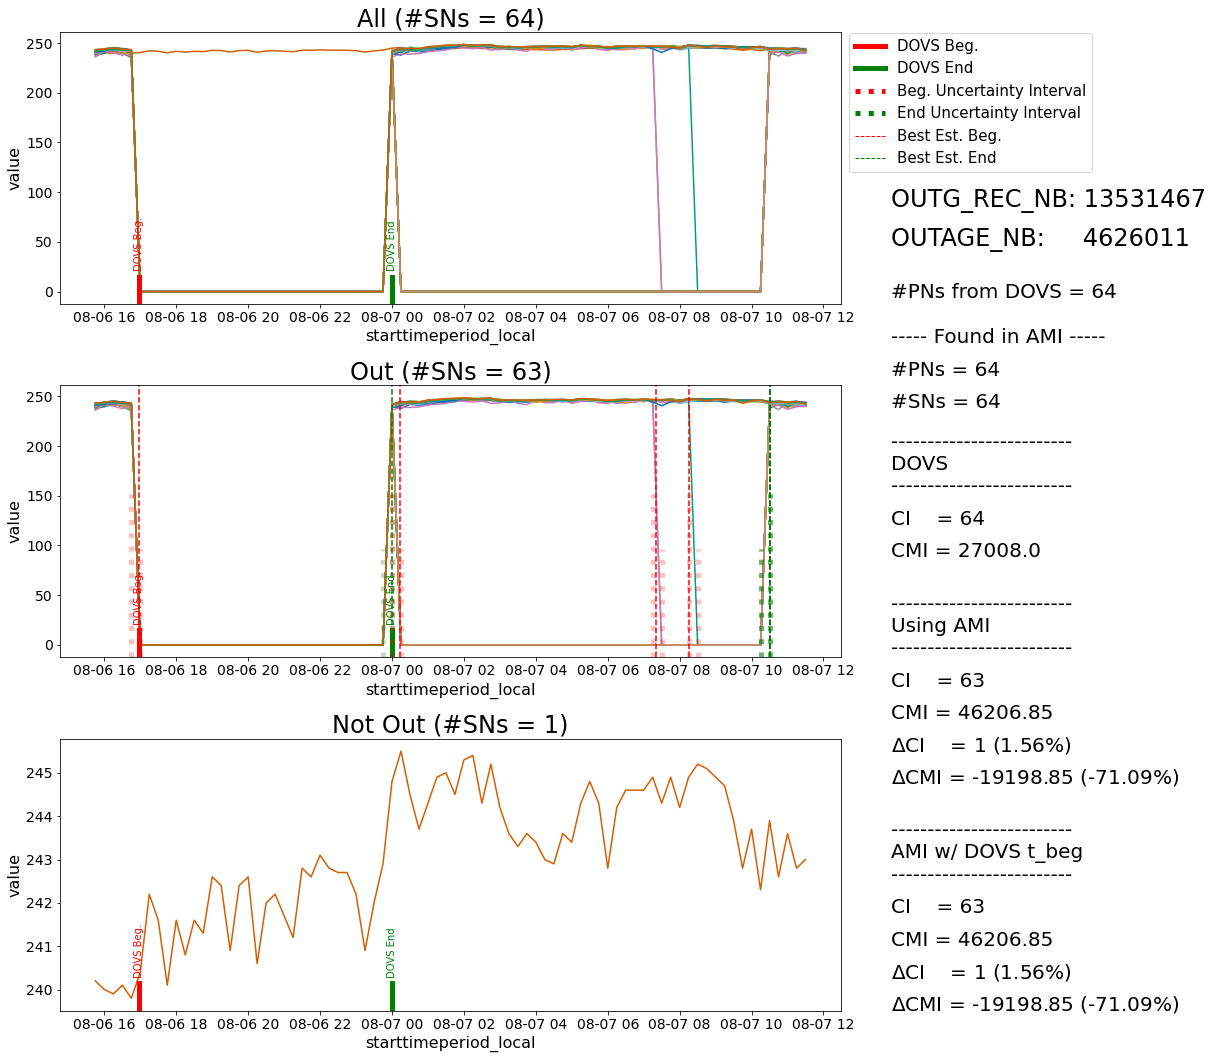

In [149]:
if means_df is not None:
    cnsrvtv_out_t_beg = means_df.min().min()
    cnsrvtv_out_t_end = means_df.max().max()
else:
    cnsrvtv_out_t_beg = dovs_outg_t_beg
    cnsrvtv_out_t_end = dovs_outg_t_end

fig, axs = Plot_General.default_subplots(
    n_x=1,
    n_y=3,
    fig_num=fig_num,
    sharex=False,
    sharey=False,
    unit_figsize_width=14,
    unit_figsize_height=6, 
    return_flattened_axes=True,
    row_major=True
)
Plot_General.adjust_subplots_args(fig, dict(hspace=0.30))

palette = Plot_General.get_standard_colors_dict(
    keys=ami_df_i['serialnumber'].unique().tolist(), 
    palette='colorblind'
)

#-------------------------
i_subplot=0
fig, axs[i_subplot] = AMINonVee.plot_usage_around_outage(
    fig=fig, 
    ax=axs[i_subplot], 
    data=ami_df_i, 
    x='starttimeperiod_local', 
    y='value', 
    hue='serialnumber', 
    out_t_beg=dovs_outg_t_beg, 
    out_t_end=dovs_outg_t_end, 
    expand_time=pd.Timedelta('1 hour'), 
    plot_time_beg_end=[cnsrvtv_out_t_beg, cnsrvtv_out_t_end], 
    data_label='', 
    title_args=dict(label=f"All (#SNs = {ami_df_i['serialnumber'].nunique()})", fontdict=dict(fontsize=24)), 
    ax_args=None, 
    xlabel_args=None, 
    ylabel_args=None, 
    df_mean=None, 
    df_mean_col=None, 
    mean_args=None, 
    draw_outage_limits=True, 
    draw_outage_limits_kwargs=dict(alpha=1.0, linewidth=5.0, ymax=0.1), 
    include_outage_limits_text=dict(
        out_t_beg_text='DOVS Beg.', 
        out_t_beg_ypos=(0.12, 'ax_coord'), 
        out_t_beg_va='bottom', 
        out_t_beg_ha='center', 
        out_t_beg_color='red', 
        #-----
        out_t_end_text='DOVS End', 
        out_t_end_ypos=(0.12, 'ax_coord'), 
        out_t_end_va='bottom', 
        out_t_end_ha='center', 
        out_t_end_color='green', 
    ), 
    draw_without_hue_also=False, 
    seg_line_freq=None, 
    palette=palette
)
axs[i_subplot].legend().set_visible(False)
Plot_General.set_general_plotting_args(
    ax=axs[i_subplot], 
    tick_args =[
        dict(axis='x', labelrotation=0, labelsize=14.0, direction='out'), 
        dict(axis='y', labelrotation=0, labelsize=14.0, direction='out')
    ], 
    xlabel_args=dict(xlabel=axs[i_subplot].get_xlabel(), fontsize=16), 
    ylabel_args=dict(ylabel=axs[i_subplot].get_ylabel(), fontsize=16)
)


#-------------------------
i_subplot=1
if ami_df_i_part_out.shape[0]>0:
    fig, axs[i_subplot] = AMINonVee.plot_usage_around_outage(
        fig=fig, 
        ax=axs[i_subplot], 
        data=ami_df_i_part_out, 
        x='starttimeperiod_local', 
        y='value', 
        hue='serialnumber', 
        out_t_beg=dovs_outg_t_beg, 
        out_t_end=dovs_outg_t_end, 
        expand_time=pd.Timedelta('1 hour'), 
        plot_time_beg_end=[cnsrvtv_out_t_beg, cnsrvtv_out_t_end], 
        data_label='', 
        title_args=dict(label=f"Out (#SNs = {ami_df_i_part_out['serialnumber'].nunique()})", fontdict=dict(fontsize=24)), 
        ax_args=None, 
        xlabel_args=None, 
        ylabel_args=None, 
        df_mean=None, 
        df_mean_col=None, 
        mean_args=None, 
        draw_outage_limits=True, 
        draw_outage_limits_kwargs=dict(alpha=1.0, linewidth=5.0, ymax=0.1), 
        include_outage_limits_text=dict(
            out_t_beg_text='DOVS Beg.', 
            out_t_beg_ypos=(0.12, 'ax_coord'), 
            out_t_beg_va='bottom', 
            out_t_beg_ha='center', 
            out_t_beg_color='red', 
            #-----
            out_t_end_text='DOVS End', 
            out_t_end_ypos=(0.12, 'ax_coord'), 
            out_t_end_va='bottom', 
            out_t_end_ha='center', 
            out_t_end_color='green', 
        ), 
        draw_without_hue_also=False, 
        seg_line_freq=None, 
        palette=palette
    )
    axs[i_subplot].legend().set_visible(False)
    add_all_best_ests_to_axis(
        axs[i_subplot], 
        means_df, 
        line_kwargs_by_est_key=dict(
            conservative=dict(alpha=0.25, linewidth=5.0, ymax=0.6), 
            zero_times=dict(alpha=0.25, linewidth=5.0, ymax=0.4) 
        ), 
        keys_to_include=['winner', 'conservative', 'zero_times']
    )
    Plot_General.set_general_plotting_args(
        ax=axs[i_subplot], 
        tick_args =[
            dict(axis='x', labelrotation=0, labelsize=14.0, direction='out'), 
            dict(axis='y', labelrotation=0, labelsize=14.0, direction='out')
        ], 
        xlabel_args=dict(xlabel=axs[i_subplot].get_xlabel(), fontsize=16), 
        ylabel_args=dict(ylabel=axs[i_subplot].get_ylabel(), fontsize=16)
    )
else:
    axs[i_subplot].set_title(
        label=f'Out', 
        fontdict=dict(fontsize=24)
    )

#-------------------------
i_subplot=2
if ami_df_i_not_out.shape[0]>0:
    fig, axs[i_subplot] = AMINonVee.plot_usage_around_outage(
        fig=fig, 
        ax=axs[i_subplot], 
        data=ami_df_i_not_out, 
        x='starttimeperiod_local', 
        y='value', 
        hue='serialnumber', 
        out_t_beg=dovs_outg_t_beg, 
        out_t_end=dovs_outg_t_end, 
        expand_time=pd.Timedelta('1 hour'), 
        plot_time_beg_end=[cnsrvtv_out_t_beg, cnsrvtv_out_t_end], 
        data_label='', 
        title_args=dict(label=f"Not Out (#SNs = {ami_df_i_not_out['serialnumber'].nunique()})", fontdict=dict(fontsize=24)), 
        ax_args=None, 
        xlabel_args=None, 
        ylabel_args=None, 
        df_mean=None, 
        df_mean_col=None, 
        mean_args=None, 
        draw_outage_limits=True, 
        draw_outage_limits_kwargs=dict(alpha=1.0, linewidth=5.0, ymax=0.1), 
        include_outage_limits_text=dict(
            out_t_beg_text='DOVS Beg.', 
            out_t_beg_ypos=(0.12, 'ax_coord'), 
            out_t_beg_va='bottom', 
            out_t_beg_ha='center', 
            out_t_beg_color='red', 
            #-----
            out_t_end_text='DOVS End', 
            out_t_end_ypos=(0.12, 'ax_coord'), 
            out_t_end_va='bottom', 
            out_t_end_ha='center', 
            out_t_end_color='green', 
        ), 
        draw_without_hue_also=False, 
        seg_line_freq=None, 
        palette=palette
    )
    axs[i_subplot].legend().set_visible(False)
    Plot_General.set_general_plotting_args(
        ax=axs[i_subplot], 
        tick_args =[
            dict(axis='x', labelrotation=0, labelsize=14.0, direction='out'), 
            dict(axis='y', labelrotation=0, labelsize=14.0, direction='out')
        ], 
        xlabel_args=dict(xlabel=axs[i_subplot].get_xlabel(), fontsize=16), 
        ylabel_args=dict(ylabel=axs[i_subplot].get_ylabel(), fontsize=16)
    )
else:
    axs[i_subplot].set_title(label='Not Out', fontdict=dict(fontsize=24))
        

#--------------------------------------------------
# Add legend to first plot
patch_dovs_beg = Line2D(
    [0], [0], color='red', 
    alpha=1.0, linewidth=5.0, linestyle='-', 
    label='DOVS Beg.'
)
patch_dovs_end = Line2D(
    [0], [0], color='green', 
    alpha=1.0, linewidth=5.0, linestyle='-', 
    label='DOVS End'
)
#-----
patch_ui_beg =  Line2D(
    [0], [0], color='red', 
    alpha=1.0, linewidth=5.0, linestyle=':', 
    label='Beg. Uncertainty Interval'
)
patch_ui_end =  Line2D(
    [0], [0], color='green', 
    alpha=1.0, linewidth=5.0, linestyle=':', 
    label='End Uncertainty Interval'
)
#-----
patch_best_beg =  Line2D(
    [0], [0], color='red', 
    alpha=1.0, linewidth=1.0, linestyle='--', 
    label='Best Est. Beg.'
)
patch_best_end =  Line2D(
    [0], [0], color='green', 
    alpha=1.0, linewidth=1.0, linestyle='--', 
    label='Best Est. End'
)
#-------------------------
handles=[patch_dovs_beg, patch_dovs_end, patch_ui_beg, patch_ui_end, patch_best_beg, patch_best_end]
#-------------------------
leg_1 = axs[0].legend(
    title=None, 
    handles=handles, 
    bbox_to_anchor=(1, 1.025), 
    loc='upper left', 
    fontsize=15
)        
        
#--------------------------------------------------
ci_info_fontsize = 20
left_text_x=0.95
right_text_x = 1.05
shift_text_down = 0

fig.text(left_text_x, 0.745-shift_text_down, f'OUTG_REC_NB: {outg_rec_nb}', fontsize=ci_info_fontsize+4)
fig.text(left_text_x, 0.715-shift_text_down, f"OUTAGE_NB:     {outage_nb}", fontsize=ci_info_fontsize+4)

fig.text(left_text_x, 0.675-shift_text_down, f"#PNs from DOVS = {n_PNs_dovs}", fontsize=ci_info_fontsize)

fig.text(left_text_x, 0.640-shift_text_down, "----- Found in AMI -----", fontsize=ci_info_fontsize)
fig.text(left_text_x, 0.615-shift_text_down, f"#PNs = {n_PNs}", fontsize=ci_info_fontsize)
fig.text(left_text_x, 0.590-shift_text_down, f"#SNs = {n_SNs}", fontsize=ci_info_fontsize)

fig.text(left_text_x, 0.525-shift_text_down, '-----'*5+'\nDOVS\n'+'-----'*5, fontsize=ci_info_fontsize)
fig.text(left_text_x, 0.500-shift_text_down, f'CI    = {ci_dovs}', fontsize=ci_info_fontsize)
fig.text(left_text_x, 0.475-shift_text_down, f'CMI = {np.round(cmi_dovs, decimals=2)}', fontsize=ci_info_fontsize)

fig.text(left_text_x, 0.400-shift_text_down, '-----'*5+'\nUsing AMI\n'+'-----'*5, fontsize=ci_info_fontsize)
fig.text(left_text_x, 0.375-shift_text_down, f'CI    = {ci_ami}', fontsize=ci_info_fontsize)
fig.text(left_text_x, 0.350-shift_text_down, f'CMI = {np.round(cmi_ami, decimals=2)}', fontsize=ci_info_fontsize)
#-----
fig.text(
    left_text_x, 0.325-shift_text_down, 
    f'$\Delta$CI    = {ci_dovs-ci_ami} ({np.round(100*(ci_dovs-ci_ami)/ci_dovs, decimals=2)}%)', 
    fontsize=ci_info_fontsize
)
fig.text(
    left_text_x, 0.300-shift_text_down, 
    f'$\Delta$CMI = {np.round(cmi_dovs-cmi_ami, decimals=2)} ({np.round(100*(cmi_dovs-cmi_ami)/cmi_dovs, decimals=2)}%)', 
    fontsize=ci_info_fontsize
)

fig.text(left_text_x, 0.225-shift_text_down, '-----'*5+'\nAMI w/ DOVS t_beg\n'+'-----'*5, fontsize=ci_info_fontsize)
fig.text(left_text_x, 0.200-shift_text_down, f'CI    = {ci_ami_dovs_beg}', fontsize=ci_info_fontsize)
fig.text(left_text_x, 0.175-shift_text_down, f'CMI = {np.round(cmi_ami_dovs_beg, decimals=2)}', fontsize=ci_info_fontsize)
#-----
fig.text(
    left_text_x, 0.150-shift_text_down, 
    f'$\Delta$CI    = {ci_dovs-ci_ami_dovs_beg} ({np.round(100*(ci_dovs-ci_ami_dovs_beg)/ci_dovs, decimals=2)}%)', 
    fontsize=ci_info_fontsize
)
fig.text(
    left_text_x, 0.125-shift_text_down, 
    f'$\Delta$CMI = {np.round(cmi_dovs-cmi_ami_dovs_beg, decimals=2)} ({np.round(100*(cmi_dovs-cmi_ami_dovs_beg)/cmi_dovs, decimals=2)}%)', 
    fontsize=ci_info_fontsize
)

fig_num += 1

In [150]:
all_detailed_summary_dfs=[]
ci_cmi_summary_df = pd.DataFrame(columns=[
    'outg_rec_nb', 
    'ci_dovs',  'ci_ami', 'ci_ami_dovs_beg', 
    'cmi_dovs', 'cmi_ami', 'cmi_ami_dovs_beg'
])


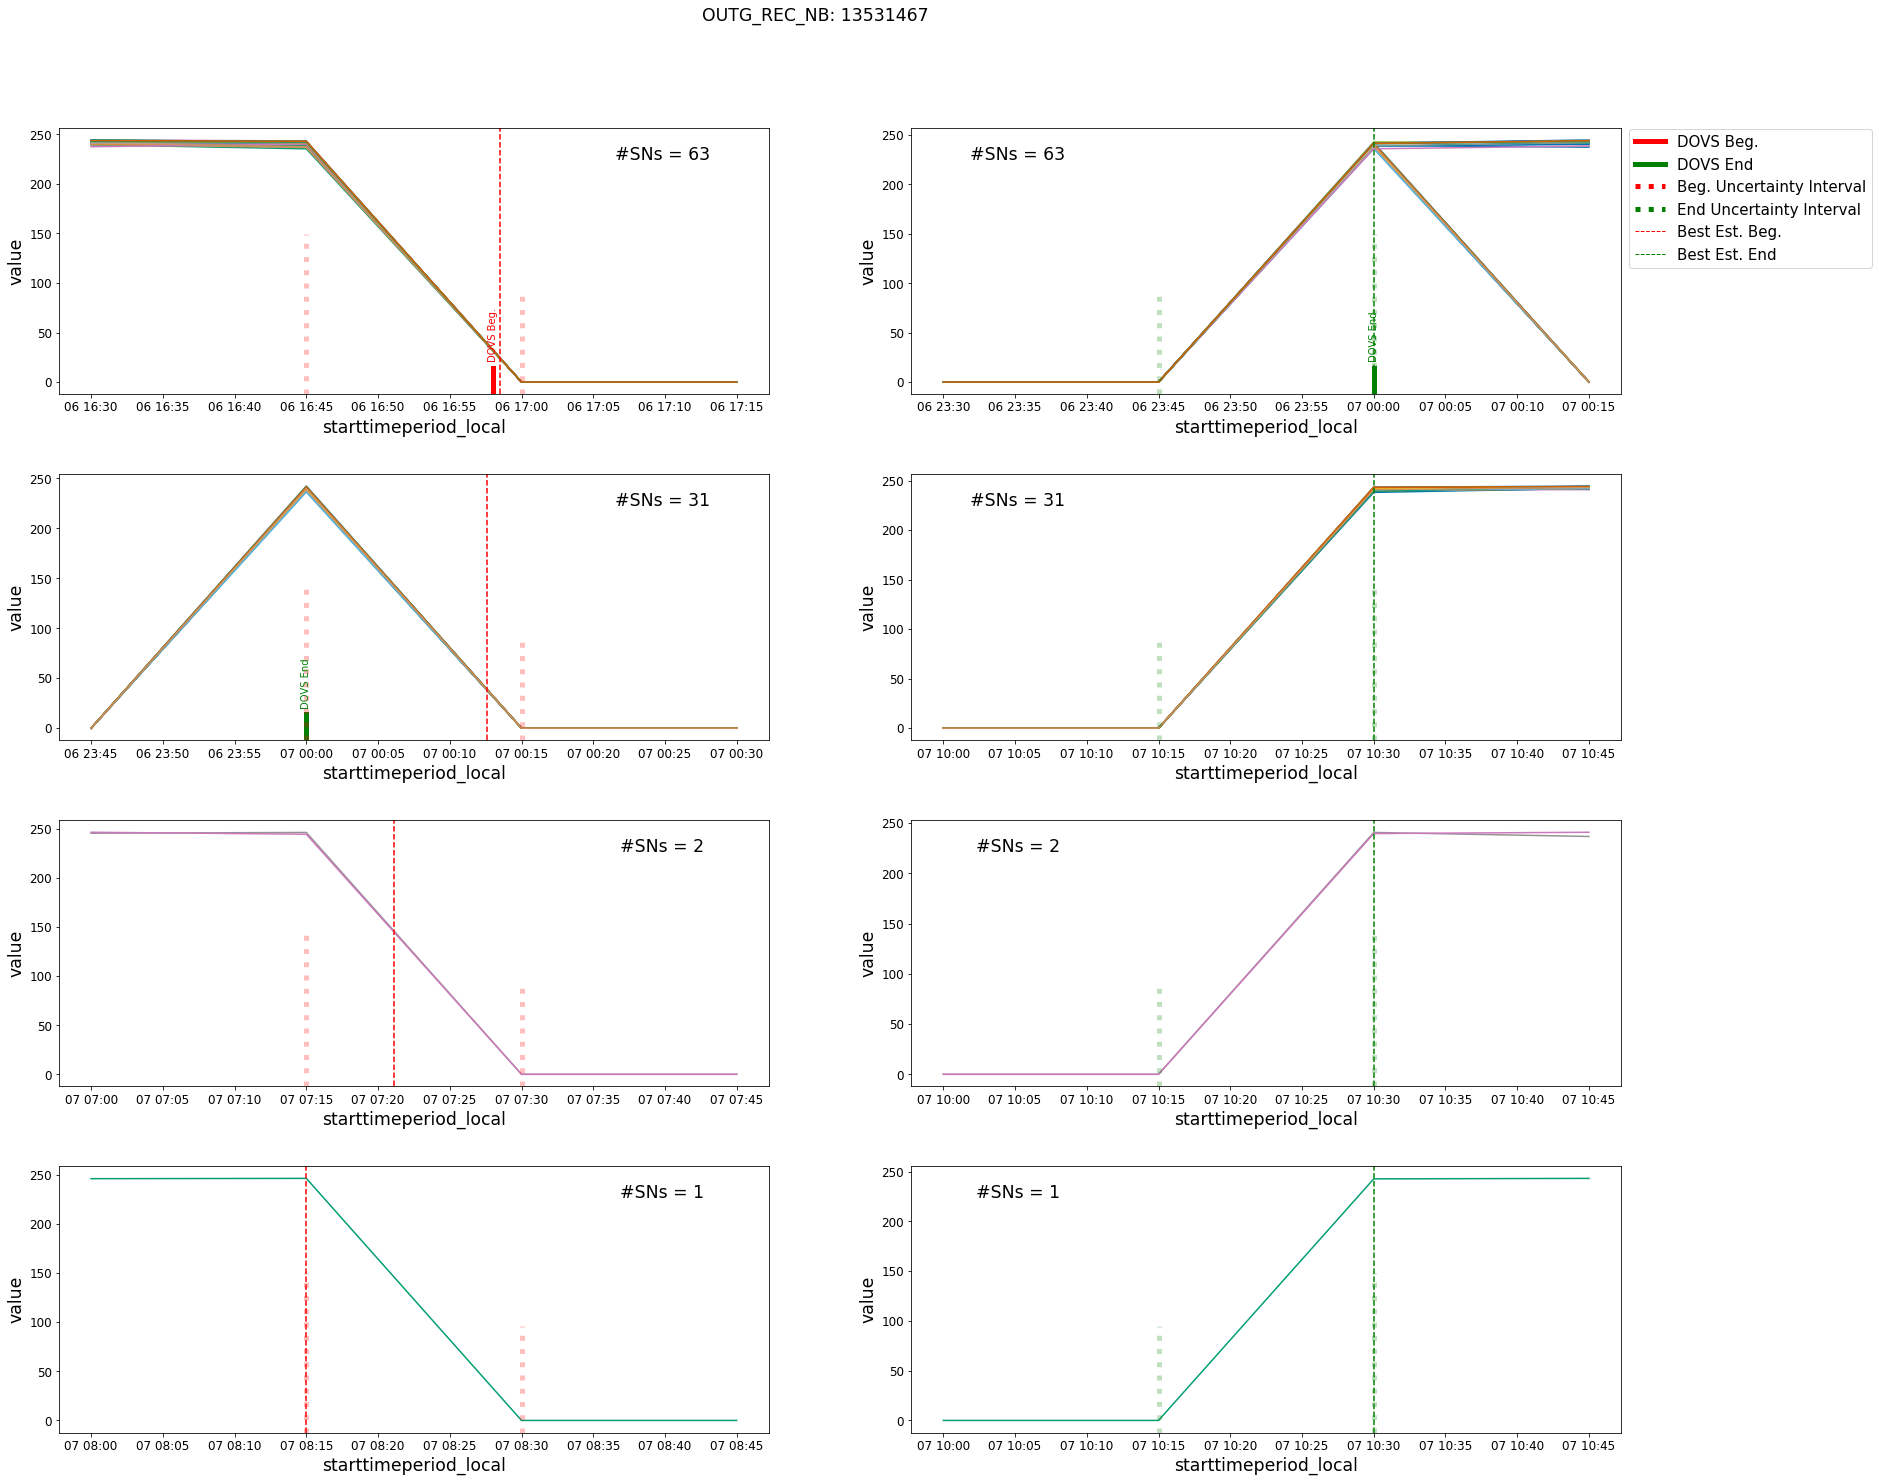

In [151]:
if means_df is not None:
    means_df = means_df.sort_values(by=['winner_min', 'winner_max'])
    fig, axs = Plot_General.default_subplots(
        n_x=2, 
        n_y=means_df.shape[0], 
        fig_num=fig_num
    )
    if means_df.shape[0]==1:
        axs = [axs]
    Plot_General.adjust_subplots_args(fig, dict(hspace=0.30))

    palette = Plot_General.get_standard_colors_dict(
        keys=ami_df_i['serialnumber'].unique().tolist(), 
        palette='colorblind'
    )

    #-------------------------
    for i_row in range(means_df.shape[0]):
        db_label = means_df.iloc[i_row].name
        ami_df_i_subset = ami_df_i[ami_df_i['aep_premise_nb'].isin(
            best_ests_df_w_db_lbl[best_ests_df_w_db_lbl['db_label']==db_label]['PN'].tolist()
        )]
        n_SNs = ami_df_i_subset['serialnumber'].nunique()
        #****************************************
        fig, axs[i_row][0] = AMINonVee.plot_usage_around_outage(
            fig=fig, 
            ax=axs[i_row][0], 
            data=ami_df_i_subset, 
            x='starttimeperiod_local', 
            y='value', 
            hue='serialnumber', 
            out_t_beg=dovs_outg_t_beg, 
            out_t_end=dovs_outg_t_end, 
            expand_time=pd.Timedelta('15 minutes'), 
            plot_time_beg_end=[means_df.iloc[i_row]['conservative_min'], means_df.iloc[i_row]['zero_times_min']], 
            data_label='', 
            title_args=None, 
            ax_args=None, 
            xlabel_args=None, 
            ylabel_args=None, 
            df_mean=None, 
            df_mean_col=None, 
            mean_args=None, 
            draw_outage_limits=True, 
            draw_outage_limits_kwargs=dict(alpha=1.0, linewidth=5.0, ymax=0.1), 
            include_outage_limits_text=dict(
                out_t_beg_text='DOVS Beg.', 
                out_t_beg_ypos=(0.12, 'ax_coord'), 
                out_t_beg_va='bottom', 
                out_t_beg_ha='center', 
                out_t_beg_color='red', 
                #-----
                out_t_end_text='DOVS End', 
                out_t_end_ypos=(0.12, 'ax_coord'), 
                out_t_end_va='bottom', 
                out_t_end_ha='center', 
                out_t_end_color='green', 
            ),
            draw_without_hue_also=False, 
            seg_line_freq=None, 
            palette=palette
        )
        axs[i_row][0].legend().set_visible(False)
        add_all_best_ests_to_axis(
            axs[i_row][0], 
            means_df.iloc[[i_row]], 
            line_kwargs_by_est_key=dict(
                conservative=dict(alpha=0.25, linewidth=5.0, ymax=0.6), 
                zero_times=dict(alpha=0.25, linewidth=5.0, ymax=0.4) 
            ), 
            keys_to_include=['winner', 'conservative', 'zero_times'], 
            expand_ax_to_accommodate=False
        )
        axs[i_row][0].text(0.85, 0.9, f'#SNs = {n_SNs}', ha='center', va='center', transform=axs[i_row][0].transAxes, fontsize='xx-large')
        Plot_General.set_general_plotting_args(
            ax=axs[i_row][0], 
            tick_args =[
                dict(axis='x', labelrotation=0, labelsize='large', direction='out'), 
                dict(axis='y', labelrotation=0, labelsize='large', direction='out')
            ], 
            xlabel_args=dict(xlabel=axs[i_row][0].get_xlabel(), fontsize='xx-large'), 
            ylabel_args=dict(ylabel=axs[i_row][0].get_ylabel(), fontsize='xx-large')
        )
        #****************************************
        fig, axs[i_row][1] = AMINonVee.plot_usage_around_outage(
            fig=fig, 
            ax=axs[i_row][1], 
            data=ami_df_i_subset, 
            x='starttimeperiod_local', 
            y='value', 
            hue='serialnumber', 
            out_t_beg=dovs_outg_t_beg, 
            out_t_end=dovs_outg_t_end, 
            expand_time=pd.Timedelta('15 minutes'), 
            plot_time_beg_end=[means_df.iloc[i_row]['zero_times_max'], means_df.iloc[i_row]['conservative_max']], 
            data_label='', 
            title_args=None, 
            ax_args=None, 
            xlabel_args=None, 
            ylabel_args=None, 
            df_mean=None, 
            df_mean_col=None, 
            mean_args=None, 
            draw_outage_limits=True, 
            draw_outage_limits_kwargs=dict(alpha=1.0, linewidth=5.0, ymax=0.1), 
            include_outage_limits_text=dict(
                out_t_beg_text='DOVS Beg.', 
                out_t_beg_ypos=(0.12, 'ax_coord'), 
                out_t_beg_va='bottom', 
                out_t_beg_ha='center', 
                out_t_beg_color='red', 
                #-----
                out_t_end_text='DOVS End', 
                out_t_end_ypos=(0.12, 'ax_coord'), 
                out_t_end_va='bottom', 
                out_t_end_ha='center', 
                out_t_end_color='green', 
            ),
            draw_without_hue_also=False, 
            seg_line_freq=None, 
            palette=palette
        )
        axs[i_row][1].legend().set_visible(False)
        add_all_best_ests_to_axis(
            axs[i_row][1], 
            means_df.iloc[[i_row]], 
            line_kwargs_by_est_key=dict(
                conservative=dict(alpha=0.25, linewidth=5.0, ymax=0.6), 
                zero_times=dict(alpha=0.25, linewidth=5.0, ymax=0.4) 
            ), 
            keys_to_include=['winner', 'conservative', 'zero_times'], 
            expand_ax_to_accommodate=False
        )
        axs[i_row][1].text(0.15, 0.9, f'#SNs = {n_SNs}', ha='center', va='center', transform=axs[i_row][1].transAxes, fontsize='xx-large')
        Plot_General.set_general_plotting_args(
            ax=axs[i_row][1], 
            tick_args =[
                dict(axis='x', labelrotation=0, labelsize='large', direction='out'), 
                dict(axis='y', labelrotation=0, labelsize='large', direction='out')
            ], 
            xlabel_args=dict(xlabel=axs[i_row][1].get_xlabel(), fontsize='xx-large'), 
            ylabel_args=dict(ylabel=axs[i_row][1].get_ylabel(), fontsize='xx-large')
        )
        
    #--------------------------------------------------
    # Add legend to first row
    patch_dovs_beg = Line2D(
        [0], [0], color='red', 
        alpha=1.0, linewidth=5.0, linestyle='-', 
        label='DOVS Beg.'
    )
    patch_dovs_end = Line2D(
        [0], [0], color='green', 
        alpha=1.0, linewidth=5.0, linestyle='-', 
        label='DOVS End'
    )
    #-----
    patch_ui_beg =  Line2D(
        [0], [0], color='red', 
        alpha=1.0, linewidth=5.0, linestyle=':', 
        label='Beg. Uncertainty Interval'
    )
    patch_ui_end =  Line2D(
        [0], [0], color='green', 
        alpha=1.0, linewidth=5.0, linestyle=':', 
        label='End Uncertainty Interval'
    )
    #-----
    patch_best_beg =  Line2D(
        [0], [0], color='red', 
        alpha=1.0, linewidth=1.0, linestyle='--', 
        label='Best Est. Beg.'
    )
    patch_best_end =  Line2D(
        [0], [0], color='green', 
        alpha=1.0, linewidth=1.0, linestyle='--', 
        label='Best Est. End'
    )
    #-------------------------
    leg_1 = axs[0][1].legend(
        title=None, 
        handles=[patch_dovs_beg, patch_dovs_end, patch_ui_beg, patch_ui_end, patch_best_beg, patch_best_end], 
        bbox_to_anchor=(1, 1.025), 
        loc='upper left', 
        fontsize=15
    )    
        
    #-------------------------
    fig.suptitle(f"OUTG_REC_NB: {outg_rec_nb}", y=0.95, fontsize='xx-large')
    #-------------------------
    # pdf.savefig(fig, bbox_inches='tight')
    
    fig_num+=1

In [152]:
# pdf.close()

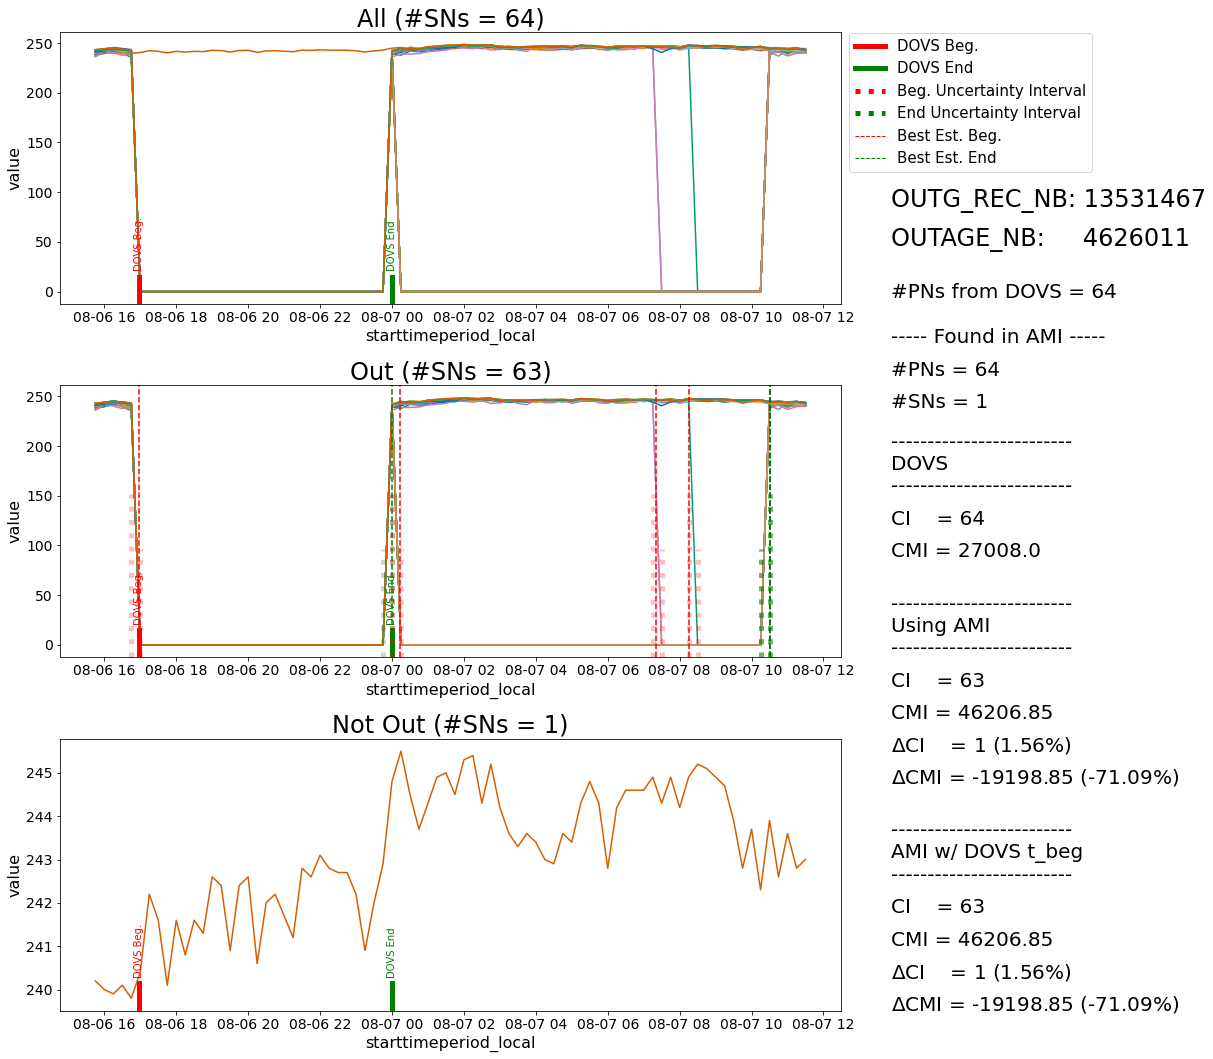

In [153]:
fig, axs = plot_all_out_not(
    fig_num              = fig_num, 
    ami_df_i             = ami_df_i, 
    ami_df_i_part_out    = ami_df_i_part_out, 
    ami_df_i_not_out     = ami_df_i_not_out, 
    dovs_outg_t_beg      = dovs_outg_t_beg, 
    dovs_outg_t_end      = dovs_outg_t_end, 
    cnsrvtv_out_t_beg    = cnsrvtv_out_t_beg, 
    cnsrvtv_out_t_end    = cnsrvtv_out_t_end, 
    means_df             = means_df, 
    outg_rec_nb          = outg_rec_nb, 
    outage_nb            = outage_nb, 
    n_PNs_dovs           = n_PNs_dovs, 
    n_PNs                = n_PNs, 
    n_SNs                = n_SNs, 
    ci_dovs              = ci_dovs, 
    cmi_dovs             = cmi_dovs, 
    ci_ami               = ci_ami, 
    cmi_ami              = cmi_ami, 
    ci_ami_dovs_beg      = ci_ami_dovs_beg, 
    cmi_ami_dovs_beg     = cmi_ami_dovs_beg, 
    expand_time          = pd.Timedelta('1 hour'), 
    mean_keys_to_include = ['winner', 'conservative', 'zero_times']
)
fig_num += 1

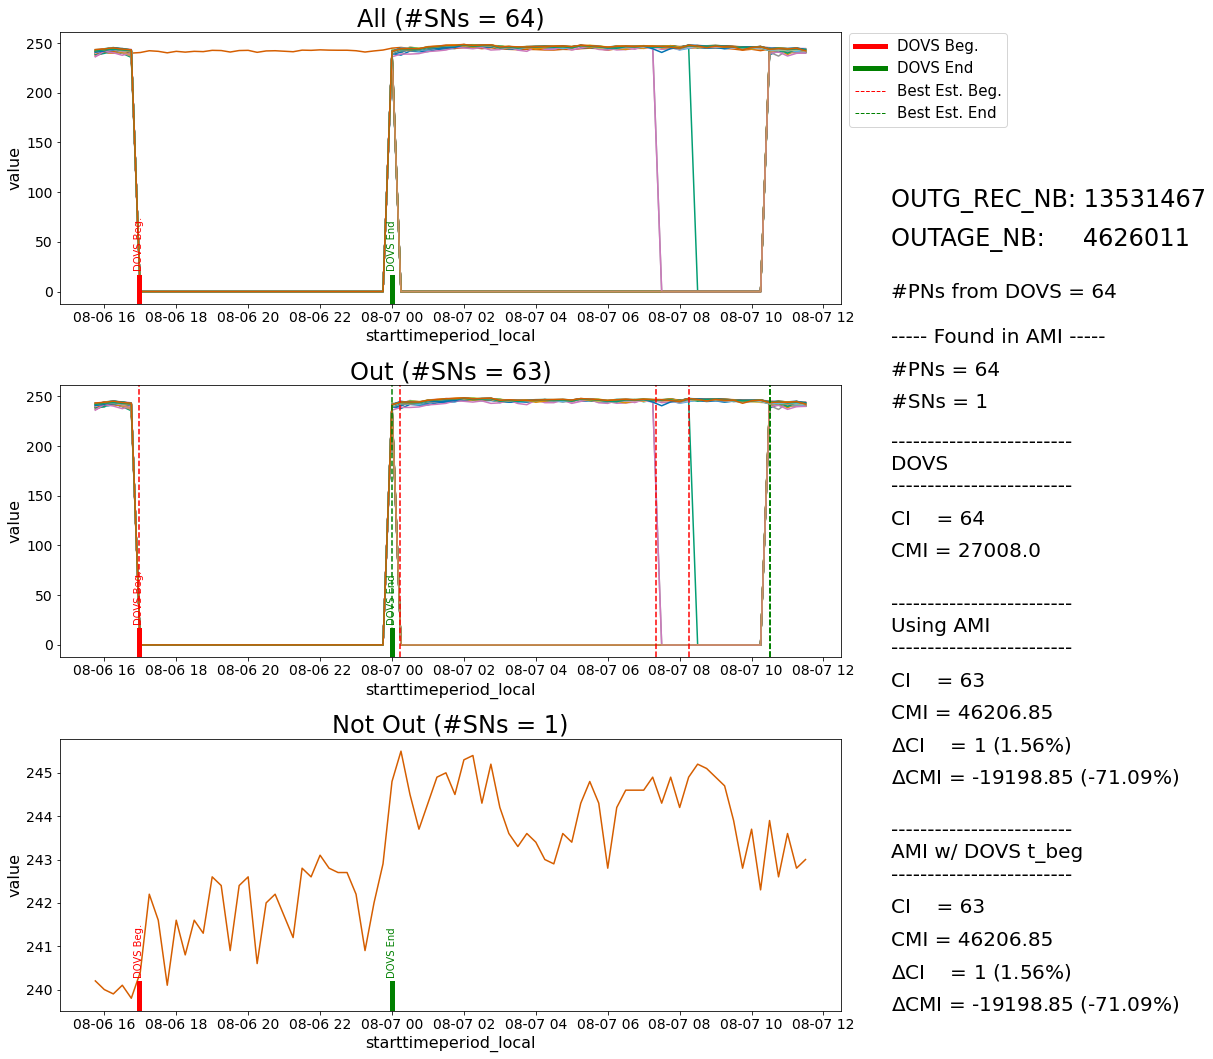

In [154]:
fig, axs = plot_all_out_not(
    fig_num              = fig_num, 
    ami_df_i             = ami_df_i, 
    ami_df_i_part_out    = ami_df_i_part_out, 
    ami_df_i_not_out     = ami_df_i_not_out, 
    dovs_outg_t_beg      = dovs_outg_t_beg, 
    dovs_outg_t_end      = dovs_outg_t_end, 
    cnsrvtv_out_t_beg    = cnsrvtv_out_t_beg, 
    cnsrvtv_out_t_end    = cnsrvtv_out_t_end, 
    means_df             = means_df_dovs_beg, 
    outg_rec_nb          = outg_rec_nb, 
    outage_nb            = outage_nb, 
    n_PNs_dovs           = n_PNs_dovs, 
    n_PNs                = n_PNs, 
    n_SNs                = n_SNs, 
    ci_dovs              = ci_dovs, 
    cmi_dovs             = cmi_dovs, 
    ci_ami               = ci_ami, 
    cmi_ami              = cmi_ami, 
    ci_ami_dovs_beg      = ci_ami_dovs_beg, 
    cmi_ami_dovs_beg     = cmi_ami_dovs_beg, 
    expand_time          = pd.Timedelta('1 hour'), 
    mean_keys_to_include = ['winner']
)

fig_num += 1